In [1]:
# Expected directory structure:
# qae_architectures/
# ├── Jacob/
# │   └── noisy_encoder_qae_Jacob.ipynb  (this file)
# ├── jacobs_examples/aintern/data/    (data files)
# └── qae_utils/                       (utility functions)

import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import json
import os
from sklearn.model_selection import train_test_split

import sys

# This notebook is in Jacob/ folder, so we need to go up one level to qae_architectures/
current_dir = os.path.dirname(os.path.abspath(''))
parent_dir = os.path.dirname(current_dir) if os.path.basename(current_dir) == 'Jacob' else current_dir

# Add both potential paths for maximum compatibility
sys.path.insert(0, parent_dir)  # Primary path
sys.path.insert(0, '../')       # Alternative path

# Import
try:
    from qae_utils.Files import read_ts_file, read_json_file
    print("Imports successful!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Make sure you're running from the Jacob/ folder within qae_architectures/")
    print("Expected structure: qae_architectures/Jacob/noisy_encoder_qae_Jacob.ipynb")
    
    # Final fallback with absolute path construction
    try:
        import os.path
        qae_utils_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'qae_utils')
        sys.path.insert(0, os.path.dirname(qae_utils_path))
        from qae_utils.Files import read_ts_file, read_json_file
        print("Absolute path fallback successful!")
    except ImportError:
        print("All import attempts failed - check file structure")
        raise

print("Noisy Encoder QAE Notebook initialized")

Imports successful!
Noisy Encoder QAE Notebook initialized


In [2]:
# Load the Mackey-Glass data (same as Half-QAE)
DATA_PATH = '../jacobs_examples/aintern/data' 
DATA_NAME = 'mackey_glass'

try:
    data_folders = [f for f in os.listdir(DATA_PATH) if f.startswith(DATA_NAME)]
    if not data_folders:
        raise FileNotFoundError("No Mackey-Glass data found. Please run the data generation notebook first.")
    
    data_folder = data_folders[0]
    print(f"Using data from: {data_folder}")
    print(f"Full data path: {DATA_PATH}/{data_folder}")
    
    X = read_ts_file(f'{DATA_PATH}/{data_folder}/x_org.arr')
    y = read_ts_file(f'{DATA_PATH}/{data_folder}/y_org.arr')
    info = read_json_file(f'{DATA_PATH}/{data_folder}/info.json')
    
    print(f"Loaded {len(y)} samples")
    print(f"Data range: [{np.min(y):.3f}, {np.max(y):.3f}]")
    print(f"Scale info: low={info['scale_low']}, high={info['scale_high']}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Looking for data in: {os.path.abspath(DATA_PATH)}")
    print("Make sure you've run the data generation notebook first.")
    print("Expected structure: qae_architectures/Jacob/ and qae_architectures/jacobs_examples/aintern/data/")

Using data from: mackey_glass_n100
Full data path: ../jacobs_examples/aintern/data/mackey_glass_n100
Loaded 100 samples
Data range: [0.230, 0.789]
Scale info: low=0.2, high=0.8


In [3]:
# Encoder Architecture Parameters (same as Half-QAE)
n_qubits = 4     # Total qubits
n_latent = 2     
n_trash = n_qubits - n_latent 
n_layers = 2

print(f"Denoising Encoder Architecture:")
print(f"- Total qubits: {n_qubits}")
print(f"- Latent space: {n_latent} qubits")  
print(f"- Trash space: {n_trash} qubits")
print(f"- Task: Noisy Input → Clean Latent Representation")

# Create quantum device
dev = qml.device('default.qubit', wires=n_qubits)

Denoising Encoder Architecture:
- Total qubits: 4
- Latent space: 2 qubits
- Trash space: 2 qubits
- Task: Noisy Input → Clean Latent Representation


In [4]:
# Load Trained V9 Half-QAE Decoder 
print("Loading trained V9 Half-QAE decoder for reference...")

try:
    # FIXED: Look for your successful V9 model
    model_files = [f for f in os.listdir(f'{DATA_PATH}/{data_folder}') 
                   if f.startswith('half_qae_v9_compression_success.json') and f.endswith('.json')]
    
    if not model_files:
        # Fallback to any half-qae model
        model_files = [f for f in os.listdir(f'{DATA_PATH}/{data_folder}') 
                       if 'half_qae' in f and f.endswith('.json')]
    
    if not model_files:
        raise FileNotFoundError("No trained Half-QAE model found. Please run the Half-QAE V9 training first.")
    
    model_file = model_files[0]  # Use the V9 model
    model_path = f'{DATA_PATH}/{data_folder}/{model_file}'
    
    with open(model_path, 'r') as f:
        half_qae_model = json.load(f)
    
    print(f"Loaded V9 Half-QAE model: {model_file}")
    print(f"   - Training cost: {half_qae_model['final_train_cost']:.8f}")
    print(f"   - Compression ratio: {half_qae_model.get('compression_analysis', {}).get('information_ratio', 'N/A')}")
    
    # Extract V9 decoder parameters
    trained_dec_params = pnp.array(half_qae_model['dec_params'], requires_grad=False)
    
    print(f"Extracted V9 decoder parameters:")
    print(f"   - Decoder params shape: {trained_dec_params.shape}")
    print(f"   - Architecture: V9 Isolated Trash Design")
    
except Exception as e:
    print(f"Error loading V9 Half-QAE model: {e}")
    print("Make sure you've run the Half-QAE V9 training notebook first.")
    raise

Loading trained V9 Half-QAE decoder for reference...
Loaded V9 Half-QAE model: half_qae_v9_compression_success.json
   - Training cost: 0.00220963
   - Compression ratio: 2.6973295217416835
Extracted V9 decoder parameters:
   - Decoder params shape: (12,)
   - Architecture: V9 Isolated Trash Design


In [5]:
def encoder_circuit_v9_compatible(params, x):
    """V9-Compatible encoder circuit matching your successful decoder"""
    
    # 1. Encode data into qubits (SAME as V9 decoder expects)
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=i)
    
    # 2. V9-COMPATIBLE compression layers
    n_layers = len(params) // (n_qubits * 3)
    for layer in range(n_layers):
        # Parameterized gates on ALL qubits
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RX(params[idx], wires=i)
            qml.RY(params[idx + 1], wires=i)
            qml.RZ(params[idx + 2], wires=i)
        
        # V9-COMPATIBLE entanglement pattern
        if layer == 0:  # First layer: full entanglement
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[n_qubits - 1, 0])
            
            # Force compression into latent qubits (SAME as V9)
            qml.CNOT(wires=[2, 0])  # Trash → Latent 0
            qml.CNOT(wires=[3, 1])  # Trash → Latent 1
        else:  # Later layers: focus on latent space
            qml.CNOT(wires=[0, 1])  # Latent-latent coupling

def decoder_circuit_v9_isolated(params):
    """EXACT V9 decoder from your successful model (unchanged)"""
    n_layers = len(params) // (n_latent * 3)
    
    # Phase 1: ONLY latent qubits get parameters
    for layer in range(n_layers):
        for i in range(n_latent):
            idx = layer * n_latent * 3 + i * 3
            qml.RX(params[idx], wires=i)
            qml.RY(params[idx + 1], wires=i)
            qml.RZ(params[idx + 2], wires=i)
        
        # Light entanglement ONLY between latent qubits
        if layer < n_layers - 1:
            qml.CNOT(wires=[0, 1])
    
    # Phase 2: COMPLETELY INDEPENDENT trash initialization (SAME as V9)
    qml.RX(np.pi/3, wires=2)
    qml.RY(np.pi/4, wires=2)
    qml.RZ(np.pi/6, wires=2)
    
    qml.RY(-np.pi/3, wires=3)
    qml.RX(np.pi/5, wires=3)  
    qml.RZ(-np.pi/4, wires=3)

In [6]:
# Mentor's improved noise and data preparation functions
def ts_add_noise(y, noise_level=0.05):
    """Add Gaussian noise scaled to data range"""
    data_range = info['scale_high'] - info['scale_low']
    noise = noise_level * data_range * np.random.normal(size=len(y))
    return np.clip(y + noise, info['scale_low'], info['scale_high'])

def ts_wind_make(ts, wind_size, wind_step):
    """Create sliding windows"""
    return np.array([ts[i:i+wind_size] for i in range(0, len(ts)-wind_size+1, wind_step)])

def create_denoising_data(y, noise_level=0.05, wind_size=4, wind_step=1, split=0.75):
    """Create denoising dataset"""
    # Create pure windows first
    pure_windows = ts_wind_make(y, wind_size, wind_step)
    
    # Split into train/test
    split_idx = int(len(pure_windows) * split)
    pure_train = pure_windows[:split_idx]
    pure_test = pure_windows[split_idx:]
    
    # Noisy versions dynamically during training
    return pure_train, pure_test

# Setup
noise_level = 0.05
wind_size = n_qubits
wind_step = 1

pure_train_windows, pure_test_windows = create_denoising_data(
    y, noise_level=noise_level, wind_size=wind_size, wind_step=wind_step
)

print(f"Data preparation:")
print(f"- Training windows: {len(pure_train_windows)} pure windows")
print(f"- Test windows: {len(pure_test_windows)} pure windows") 
print(f"- Noise will be added dynamically during training")
print(f"- Window size: {wind_size}, Step: {wind_step}, Noise level: {noise_level}")

Data preparation:
- Training windows: 72 pure windows
- Test windows: 25 pure windows
- Noise will be added dynamically during training
- Window size: 4, Step: 1, Noise level: 0.05


In [7]:
# V9-Compatible parameter calculation
n_layers = 2  # SAME as V9 decoder
enc_param_shape = n_layers * n_qubits * 3  # ALL qubits for compression
dec_param_shape = n_layers * n_latent * 3  # Only latent qubits for expansion

print(f"V9-COMPATIBLE QAE ARCHITECTURE:")
print(f"- Encoder parameters: {enc_param_shape} (covers all {n_qubits} qubits)")
print(f"- Decoder parameters: {dec_param_shape} (covers {n_latent} latent qubits)")
print(f"- Layers: {n_layers} (SAME as V9)")
print(f"- Architecture: V9-Compatible Half-QAE")

# V9-Compatible initialization (SAME scale as successful V9)
np.random.seed(1000)  # SAME seed as V9 success
init_scale = 0.8  # SAME as V9 successful training

init_params = pnp.array(
    np.random.normal(0, init_scale, enc_param_shape),  # Normal distribution like V9
    requires_grad=True
)

print(f"V9-Compatible encoder parameters initialized: {len(init_params)}")
print(f"Using same successful V9 scale: {init_scale}")

V9-COMPATIBLE QAE ARCHITECTURE:
- Encoder parameters: 24 (covers all 4 qubits)
- Decoder parameters: 12 (covers 2 latent qubits)
- Layers: 2 (SAME as V9)
- Architecture: V9-Compatible Half-QAE
V9-Compatible encoder parameters initialized: 24
Using same successful V9 scale: 0.8


In [8]:
# ...existing code...
def build_adjoint_init_from_decoder(dec_params):
    """
    Seed encoder params from the inverse of the decoder's single-qubit rotations
    on latent wires (0,1). Trash wires (2,3) start at zero.
    """
    enc = np.zeros(enc_param_shape, dtype=float)
    dec = np.array(dec_params, dtype=float)

    for layer in range(n_layers):
        for i in range(n_latent):  # decoder has params only on latent
            dec_idx = layer * n_latent * 3 + i * 3
            rx, ry, rz = dec[dec_idx:dec_idx + 3]
            enc_idx = layer * n_qubits * 3 + i * 3
            enc[enc_idx] = -rx
            enc[enc_idx + 1] = -ry
            enc[enc_idx + 2] = -rz
    return pnp.array(enc, requires_grad=True)

# Override the random init with adjoint-based seed
init_params = build_adjoint_init_from_decoder(trained_dec_params)
print(f"Adjoint-based encoder init created: {len(init_params)} params")

Adjoint-based encoder init created: 24 params


In [10]:
ANGLE_SCALE = np.pi / 2  # keep latent in responsive region

def encode_inputs_v9(x):
    low, high = info['scale_low'], info['scale_high']
    mid = 0.5 * (low + high)
    half = max(1e-12, 0.5 * (high - low))
    for i, val in enumerate(x[:n_qubits]):
        a = (val - mid) / half   # ~[-1, 1]
        a = pnp.clip(a, -1.0, 1.0)
        qml.RY(a * ANGLE_SCALE, wires=i)


In [11]:
# V9-Compatible Training Configuration
learning_rate = 0.004
batch_size = 32
n_epochs = 100
patience = 10
# Noise augmentation range used during training
NOISE_MIN, NOISE_MAX = 0.03, 0.08

print(f"V9-Compatible Training Configuration:")
print(f"- Learning rate: {learning_rate} (V9 success setting)")
print(f"- Batch size: {batch_size} (V9 success setting)")
print(f"- Epochs: {n_epochs} (V9 success setting)")
print(f"- Patience: {patience}")

@qml.qnode(dev, interface="autograd", diff_method="backprop")
def denoiser_qnode(enc_params, x_noisy):
    encode_inputs_v9(x_noisy)
    n_l = len(enc_params) // (n_qubits * 3)
    for layer in range(n_l):
        for q in range(n_qubits):
            idx = layer * n_qubits * 3 + q * 3
            qml.RX(enc_params[idx], wires=q)
            qml.RY(enc_params[idx + 1], wires=q)
            qml.RZ(enc_params[idx + 2], wires=q)
        if layer == 0:
            for q in range(n_qubits - 1):
                qml.CNOT(wires=[q, q + 1])
            qml.CNOT(wires=[n_qubits - 1, 0])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])
        else:
            qml.CNOT(wires=[0, 1])
    decoder_circuit_v9_isolated(trained_dec_params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, interface="autograd", diff_method="backprop")
def encoder_latent_qnode(enc_params, x):
    encode_inputs_v9(x)
    n_l = len(enc_params) // (n_qubits * 3)
    for layer in range(n_l):
        for q in range(n_qubits):
            idx = layer * n_qubits * 3 + q * 3
            qml.RX(enc_params[idx], wires=q)
            qml.RY(enc_params[idx + 1], wires=q)
            qml.RZ(enc_params[idx + 2], wires=q)
        if layer == 0:
            for q in range(n_qubits - 1):
                qml.CNOT(wires=[q, q + 1])
            qml.CNOT(wires=[n_qubits - 1, 0])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])
        else:
            qml.CNOT(wires=[0, 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_latent)]

@qml.qnode(dev, interface="autograd", diff_method="backprop")
def encoder_trash_qnode(enc_params, x):
    """Measures trash (wires 2,3) after the encoder to keep them near |0>."""
    encode_inputs_v9(x)
    n_l = len(enc_params) // (n_qubits * 3)
    for layer in range(n_l):
        for q in range(n_qubits):
            idx = layer * n_qubits * 3 + q * 3
            qml.RX(enc_params[idx], wires=q)
            qml.RY(enc_params[idx + 1], wires=q)
            qml.RZ(enc_params[idx + 2], wires=q)
        if layer == 0:
            for q in range(n_qubits - 1):
                qml.CNOT(wires=[q, q + 1])
            qml.CNOT(wires=[n_qubits - 1, 0])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])
        else:
            qml.CNOT(wires=[0, 1])
    return [qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))]

print(f"V9-Compatible Encoder QNode created:")
print(f"   - Input: {n_qubits} qubits")
print(f"   - Output: {n_latent} latent qubits")
print(f"   - Parameters: {enc_param_shape}")
print(f"   - Architecture: V9-Compatible")

V9-Compatible Training Configuration:
- Learning rate: 0.004 (V9 success setting)
- Batch size: 32 (V9 success setting)
- Epochs: 100 (V9 success setting)
- Patience: 10
V9-Compatible Encoder QNode created:
   - Input: 4 qubits
   - Output: 2 latent qubits
   - Parameters: 24
   - Architecture: V9-Compatible


In [12]:
def scale_back(expvals):
    return (expvals + 1.0) / 2.0 * (info['scale_high'] - info['scale_low']) + info['scale_low']

# Reconstruction only on indices [0,1]
recon_weights = pnp.array([1.0, 1.0, 0.0, 0.0])

# Loss weights (tuned)
lambda_trash = 0.001
lambda_latent = 0.01
lambda_l2 = 0.0
lambda_improve = 0.4
lambda_improve_batch = 0.1

# Switches
LEARN_AFFINE_HEAD = True   # learn a,b per index
USE_AFFINE_CAL_RECON = True

def init_cal_head(k=2):
    a0 = pnp.ones(k, requires_grad=True)
    b0 = pnp.zeros(k, requires_grad=True)
    return [a0, b0]

def calibrated_mse_details(pred_batch, tgt_batch, eps=1e-6):
    """
    Vectorized affine calibration across batch per index (autograd-safe).
    Returns: mean calibrated MSE (scalar), per-sample MSE (B,), a, b (K,)
    """
    x = pred_batch  # (B,K)
    y = tgt_batch   # (B,K)
    mx = pnp.mean(x, axis=0)
    my = pnp.mean(y, axis=0)
    vx = pnp.mean((x - mx) ** 2, axis=0) + eps
    cov = pnp.mean((x - mx) * (y - my), axis=0)
    a = cov / vx
    b = my - a * mx
    cal = a * x + b
    per_sample_mse = pnp.mean((cal - y) ** 2, axis=1)
    return pnp.mean(per_sample_mse), per_sample_mse, a, b

def encoder_denoising_loss(packed_params, clean_batch, noisy_batch):
    """
    Recon on indices [0,1] with learnable affine head (a,b) or batch calibration,
    plus latent consistency, trash regularization, and improvement terms.
    """
    if LEARN_AFFINE_HEAD:
        enc_params, cal_head = packed_params
        a, b = cal_head
    else:
        enc_params = packed_params
        a = b = None

    idx_mask = pnp.array([0, 1])

    tgt_list, pred_list, base_list = [], [], []
    latent_cons_acc = pnp.array(0.0)
    trash_acc = pnp.array(0.0)

    for clean_w, noisy_w in zip(clean_batch, noisy_batch):
        out = pnp.array(denoiser_qnode(enc_params, noisy_w))
        out_scaled = pnp.array(scale_back(out))

        tgt_list.append(pnp.array(clean_w)[idx_mask])
        pred_list.append(out_scaled[idx_mask])
        base_list.append(pnp.array(noisy_w)[idx_mask])

        latent_noisy = pnp.array(encoder_latent_qnode(enc_params, noisy_w))
        latent_clean = pnp.array(encoder_latent_qnode(enc_params, clean_w))
        latent_cons_acc += pnp.mean((latent_noisy - latent_clean) ** 2)

        z_trash = pnp.array(encoder_trash_qnode(enc_params, noisy_w))
        trash_acc += pnp.mean(0.5 * (1.0 - z_trash))

    tgt_batch  = pnp.stack(tgt_list,  axis=0)  # (B,2)
    pred_batch = pnp.stack(pred_list, axis=0)  # (B,2)
    base_batch = pnp.stack(base_list, axis=0)  # (B,2)

    if LEARN_AFFINE_HEAD:
        cal_pred = a * pred_batch + b
        recon_per_sample = pnp.mean((cal_pred - tgt_batch) ** 2, axis=1)
        recon = pnp.mean(recon_per_sample)
        cal_reg = 1e-3 * (pnp.sum((a - 1.0) ** 2) + pnp.sum(b ** 2))
    else:
        recon, recon_per_sample, _, _ = calibrated_mse_details(pred_batch, tgt_batch)
        cal_reg = 0.0

    base_per_sample = pnp.mean((tgt_batch - base_batch) ** 2, axis=1)
    baseline = pnp.mean(base_per_sample)

    eps = 1e-8
    ratio_loss = pnp.mean(pnp.log((recon_per_sample + eps) / (base_per_sample + eps)))
    ratio_loss_batch = pnp.log((recon + eps) / (baseline + eps))

    B = len(clean_batch)
    latent_cons = latent_cons_acc / B
    prob_one_trash = trash_acc / B

    return (
        recon
        + lambda_improve * ratio_loss
        + lambda_improve_batch * ratio_loss_batch
        + lambda_latent * latent_cons
        + lambda_trash * prob_one_trash
        + cal_reg
    )

In [13]:
def grad_sanity_check(enc_init, n=16):
    clean_batch = pure_train_windows[:n]
    noisy_batch = [ts_add_noise(w, noise_level) for w in clean_batch]

    if LEARN_AFFINE_HEAD:
        enc0 = pnp.array(enc_init, requires_grad=True)
        a0, b0 = init_cal_head(2)

        def f(enc_p, a, b):
            return encoder_denoising_loss([enc_p, [a, b]], clean_batch, noisy_batch)

        g_enc, g_a, g_b = qml.grad(f, argnum=[0, 1, 2])(enc0, a0, b0)
        print("grad ‖enc‖:", float(pnp.linalg.norm(g_enc)))
        print("grad a:", g_a, "grad b:", g_b)
    else:
        enc0 = pnp.array(enc_init, requires_grad=True)
        def f(enc_p):
            return encoder_denoising_loss(enc_p, clean_batch, noisy_batch)
        g_enc = qml.grad(f)(enc0)
        print("grad ‖enc‖:", float(pnp.linalg.norm(g_enc)))

# Run once:
grad_sanity_check(init_params, n=16)

grad ‖enc‖: 0.9710335857104059
grad a: [-0.17131584  1.0881004 ] grad b: [-0.2243763   1.81320171]


In [14]:
def fit_affine_calibration(enc_params, dataset, indices=(0,1), sample=256):
    """Fit y ≈ a_j x + b_j on a small calibration set."""
    idx = np.array(indices)
    S = min(sample, len(dataset))
    tgt, pred = [], []
    eps = 1e-6
    for w in dataset[:S]:
        n = ts_add_noise(w, noise_level)
        out = pnp.array(denoiser_qnode(enc_params, n))
        den = np.array(scale_back(out), dtype=float)[idx]
        tgt.append(np.array(w)[idx]); pred.append(den)
    tgt = np.array(tgt); pred = np.array(pred)
    a, b = [], []
    for j in range(tgt.shape[1]):
        x, y = pred[:, j], tgt[:, j]
        mx, my = x.mean(), y.mean()
        vx = x.var() + eps
        cov = ((x - mx)*(y - my)).mean()
        aj = cov / vx
        bj = my - aj * mx
        a.append(aj); b.append(bj)
    return np.array(a), np.array(b)

def apply_affine(den_full, a, b, indices=(0,1)):
    den = np.array(den_full, dtype=float).copy()
    den[list(indices)] = a * den[list(indices)] + b
    return den

In [15]:
PREFIT_CAL_HEAD = True

def prefit_affine_head(enc_params, sample=256, indices=(0,1)):
    a_np, b_np = fit_affine_calibration(enc_params, pure_train_windows, indices, sample=sample)
    return pnp.array(a_np, requires_grad=True), pnp.array(b_np, requires_grad=True)

def train_encoder_denoiser(enc_init):
    # Initialize params (encoder [+ affine head]) with requires_grad preserved
    if LEARN_AFFINE_HEAD:
        enc_p0 = pnp.array(enc_init, requires_grad=True)
        if PREFIT_CAL_HEAD:
            a0, b0 = prefit_affine_head(enc_p0, sample=256, indices=(0,1))
        else:
            a0, b0 = init_cal_head(2)
        params = [enc_p0, [a0, b0]]
    else:
        params = pnp.array(enc_init, requires_grad=True)

    def clone(p):
        if LEARN_AFFINE_HEAD:
            enc_p, (a, b) = p
            return [pnp.array(enc_p, requires_grad=True),
                    [pnp.array(a, requires_grad=True), pnp.array(b, requires_grad=True)]]
        return pnp.array(p, requires_grad=True)

    lr = learning_rate
    opt = qml.AdamOptimizer(stepsize=lr)

    best_params = clone(params)
    best_val = float('inf')
    patience_ctr = 0
    train_costs, val_costs = [], []

    print("Training encoder (decoder fixed)...")
    for epoch in range(n_epochs):
        perm = np.random.permutation(len(pure_train_windows))
        epoch_cost, batches = 0.0, 0

        for i in range(0, len(pure_train_windows), batch_size):
            idx = perm[i:i+batch_size]
            clean_batch = pure_train_windows[idx]
            nl = float(np.random.uniform(NOISE_MIN, NOISE_MAX))
            noisy_batch = [ts_add_noise(w, nl) for w in clean_batch]

            def loss_fn(p):
                return encoder_denoising_loss(p, clean_batch, noisy_batch)

            params, cost = opt.step_and_cost(loss_fn, params)

            # Project encoder params without breaking autograd
            if LEARN_AFFINE_HEAD:
                enc_p, (a, b) = params
                enc_p = pnp.minimum(pnp.maximum(enc_p, -1.5), 1.5)
                # Mild clipping for head to keep it sane
                rng = float(info['scale_high'] - info['scale_low'])
                a = pnp.minimum(pnp.maximum(a, 0.1), 5.0)
                b = pnp.minimum(pnp.maximum(b, -2.0 * rng), 2.0 * rng)
                params = [
                    pnp.array(enc_p, requires_grad=True),
                    [pnp.array(a, requires_grad=True), pnp.array(b, requires_grad=True)]
                ]
            else:
                params = pnp.minimum(pnp.maximum(params, -1.5), 1.5)
                params = pnp.array(params, requires_grad=True)

            epoch_cost += float(cost); batches += 1

        avg_train = epoch_cost / max(1, batches)
        train_costs.append(avg_train)

        if epoch % 5 == 0:
            val_batch = pure_test_windows[:min(64, len(pure_test_windows))]
            val_noisy = [ts_add_noise(w, noise_level) for w in val_batch]
            val_cost = float(encoder_denoising_loss(params, val_batch, val_noisy))
            val_costs.append(val_cost)

            idx_mask = np.array([0,1])
            tgt = pnp.stack([pnp.array(c)[idx_mask] for c in val_batch], axis=0)
            base = pnp.stack([pnp.array(n)[idx_mask] for n in val_noisy], axis=0)
            preds = pnp.stack([
                pnp.array(scale_back(pnp.array(denoiser_qnode(params[0] if LEARN_AFFINE_HEAD else params, n))))[idx_mask]
                for n in val_noisy
            ], axis=0)
            if LEARN_AFFINE_HEAD:
                a, b = params[1]
                preds = a * preds + b

            noise_mse = float(pnp.mean((tgt - base) ** 2))
            denoise_mse = float(pnp.mean((tgt - preds) ** 2))
            improve_pct = 100.0 * (1.0 - denoise_mse / max(noise_mse, 1e-12))

            if val_cost < best_val - 1e-5:
                best_val, best_params, patience_ctr = val_cost, clone(params), 0
            else:
                patience_ctr += 1
                if patience_ctr in (3, 6):
                    lr *= 0.5
                    opt = qml.AdamOptimizer(stepsize=lr)
                    print(f"Reduced LR to {lr:.6f}")

            print(f"Epoch {epoch:03d} | train {avg_train:.6f} | val {val_cost:.6f} | "
                  f"baseline {noise_mse:.6f} | denoise {denoise_mse:.6f} | ΔMSE {improve_pct:.1f}%")
            if patience_ctr >= patience:
                print("Early stopping.")
                break

    return best_params, train_costs, val_costs
# ...existing code...

enc_params_trained, enc_train_costs, enc_val_costs = train_encoder_denoiser(init_params)

Training encoder (decoder fixed)...


/Users/jacobzwoniarski/anaconda3/lib/python3.11/site-packages/pennylane/_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Epoch 000 | train 2.036197 | val 2.411619 | baseline 0.000886 | denoise 0.067326 | ΔMSE -7499.4%
Epoch 005 | train 2.492868 | val 2.394625 | baseline 0.000933 | denoise 0.068053 | ΔMSE -7197.8%
Epoch 010 | train 2.286008 | val 2.292464 | baseline 0.000913 | denoise 0.067560 | ΔMSE -7303.7%
Epoch 015 | train 2.329684 | val 2.383387 | baseline 0.000941 | denoise 0.067458 | ΔMSE -7070.8%
Epoch 020 | train 2.372610 | val 2.489657 | baseline 0.000750 | denoise 0.067538 | ΔMSE -8907.1%
Reduced LR to 0.002000
Epoch 025 | train 2.244320 | val 2.307776 | baseline 0.001068 | denoise 0.067850 | ΔMSE -6255.8%
Epoch 030 | train 2.320220 | val 2.522794 | baseline 0.000782 | denoise 0.067492 | ΔMSE -8527.0%


KeyboardInterrupt: 

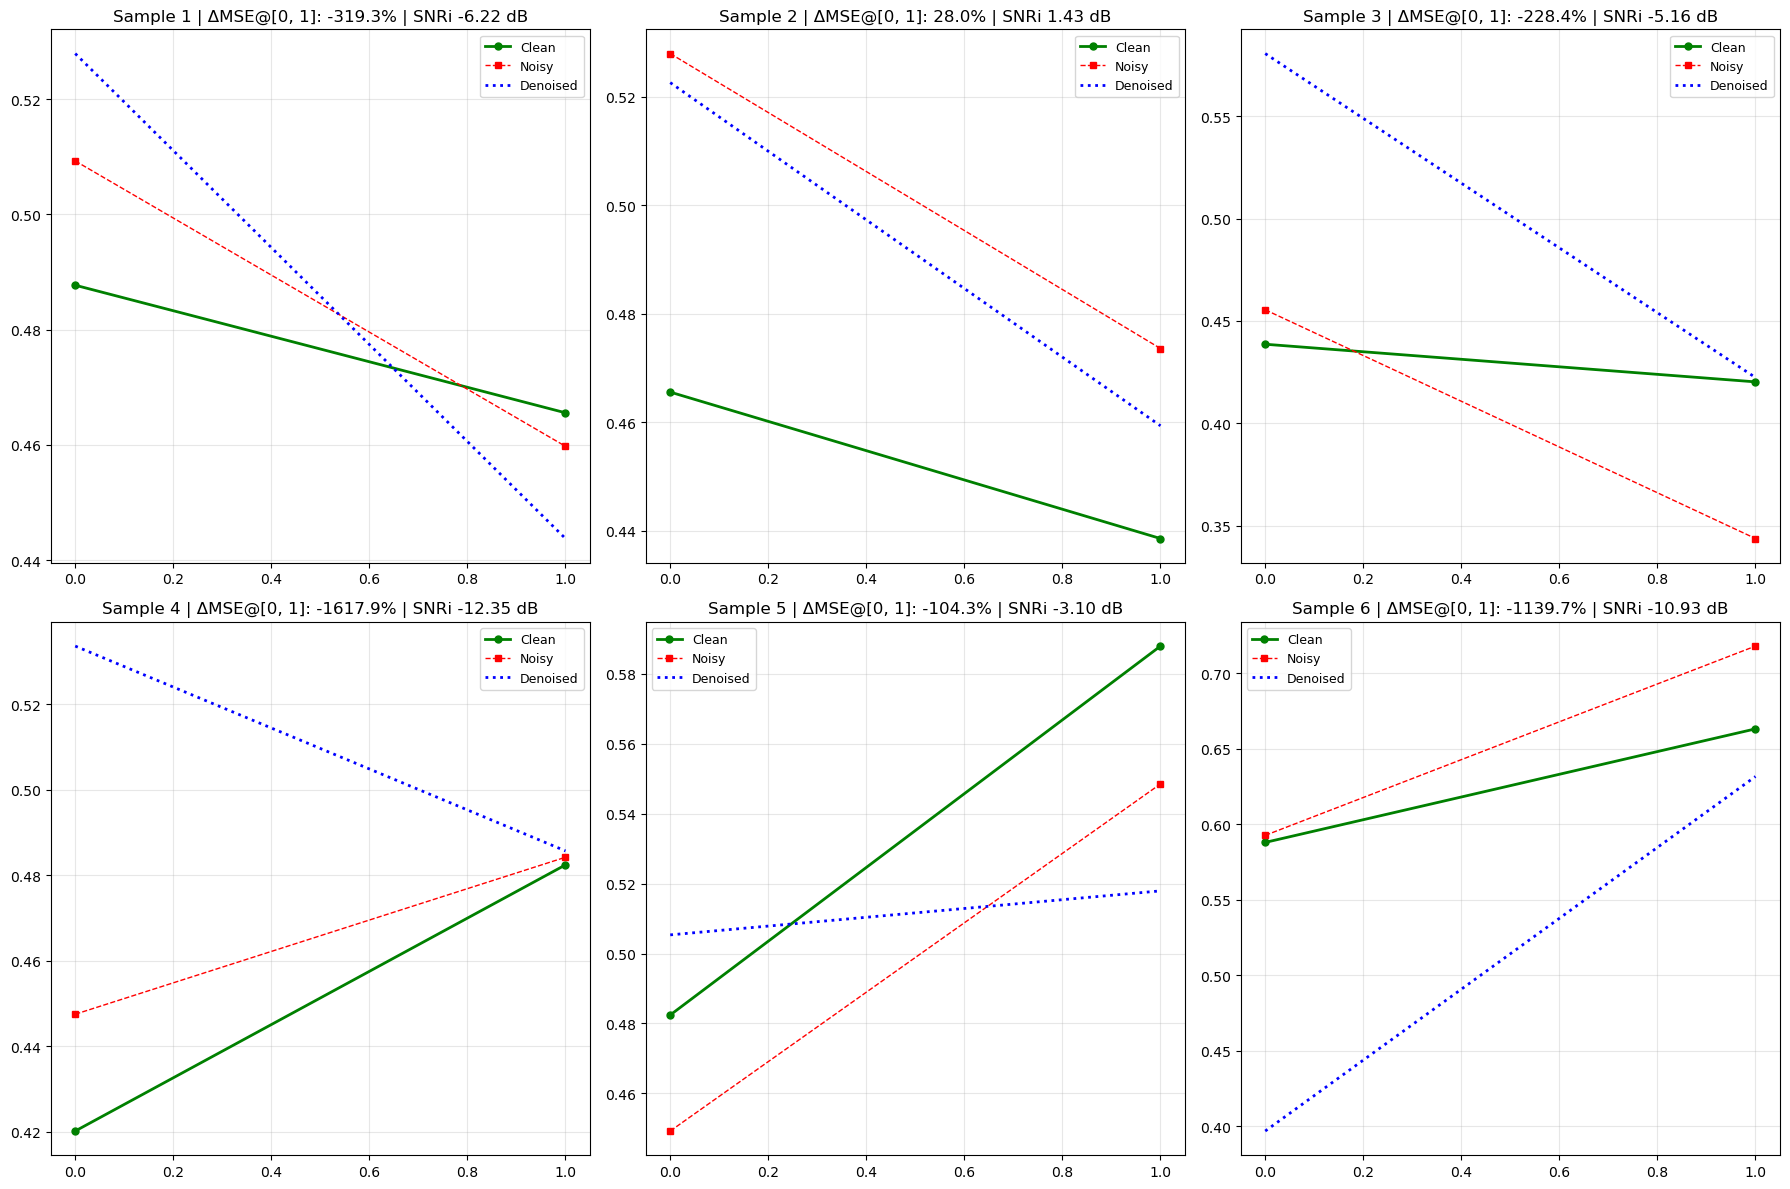

Dataset-level ΔMSE (indices [0, 1]): -349.6% | SNRi -6.53 dB
Weighted Avg ΔMSE: -349.6% | Median ΔMSE: -273.8%
Per-sample Avg ΔMSE: -563.6% | Avg SNRi: -6.06 dB
Pearson corr(clean, denoised) on [0, 1]: 0.288
Per-sample success rate (>0% ΔMSE): 16.7%


In [ ]:
# ...existing code...


def test_connection_masked(enc_params, n_samples=6, indices=(0,1), calibrate=True, learned_head=None):
    """
    Evaluate denoising with optional batch affine calibration or learned head (a,b).
    Returns (dataset ΔMSE %, dataset SNRi dB, Pearson corr).
    """
    idx = np.array(indices)
    plt.figure(figsize=(18, 12))
    per_sample_improvements, per_sample_snris = [], []
    clean_all, den_all = [], []
    eps = 1e-12

    # Select calibration method
    a = b = None
    if learned_head is not None:
        a, b = [np.array(z, dtype=float)[list(indices)] for z in learned_head]
        calibrate = False
    elif calibrate:
        a, b = fit_affine_calibration(enc_params, pure_train_windows, indices, sample=256)

    # For dataset-level metrics
    all_tgt, all_base, all_den = [], [], []

    for i in range(min(n_samples, len(pure_test_windows))):
        clean_full = pure_test_windows[i]
        noisy_full = ts_add_noise(clean_full, noise_level)

        out = pnp.array(denoiser_qnode(enc_params, noisy_full))
        den_full = scale_back(out)
        if a is not None and b is not None:
            den_full = apply_affine(den_full, a, b, indices)

        clean = clean_full[idx]
        noisy = noisy_full[idx]
        den   = np.array(den_full)[idx]

        all_tgt.append(clean); all_base.append(noisy); all_den.append(den)

        noise_mse   = float(np.mean((clean - noisy)**2))
        denoise_mse = float(np.mean((clean - den)**2))
        imp  = 100.0 * (1.0 - denoise_mse / max(noise_mse, eps))
        snri = 10.0 * np.log10(max(noise_mse, eps) / max(denoise_mse, eps))

        per_sample_improvements.append(imp); per_sample_snris.append(snri)
        clean_all.append(clean); den_all.append(den)

        plt.subplot(2, 3, i+1)
        plt.plot(clean, 'g-o', label='Clean', linewidth=2, markersize=5)
        plt.plot(noisy, 'r--s', label='Noisy', linewidth=1, markersize=4)
        plt.plot(den,   'b:',  label='Denoised', linewidth=2)
        plt.title(f'Sample {i+1} | ΔMSE@{list(idx)}: {imp:.1f}% | SNRi {snri:.2f} dB')
        plt.grid(True, alpha=0.3); plt.legend(fontsize=9)

    plt.tight_layout(); plt.show()

    clean_all = np.array(clean_all).reshape(-1)
    den_all   = np.array(den_all).reshape(-1)
    corr = float(np.corrcoef(clean_all, den_all)[0,1])

    all_tgt  = np.array(all_tgt)
    all_base = np.array(all_base)
    all_den  = np.array(all_den)
    ds_noise_mse   = float(np.mean((all_tgt - all_base)**2))
    ds_denoise_mse = float(np.mean((all_tgt - all_den)**2))
    ds_imp  = 100.0 * (1.0 - ds_denoise_mse / max(ds_noise_mse, 1e-12))
    ds_snri = 10.0 * np.log10(max(ds_noise_mse, 1e-12) / max(ds_denoise_mse, 1e-12))

    per_sample_improvements = np.array(per_sample_improvements)
    per_sample_snris = np.array(per_sample_snris)
    baselines = np.mean((all_tgt - all_base)**2, axis=1)
    w = baselines / (np.sum(baselines) + 1e-12)
    weighted_imp = float(np.sum(w * per_sample_improvements))
    median_imp = float(np.median(per_sample_improvements))

    print(f"Dataset-level ΔMSE (indices {list(idx)}): {ds_imp:.1f}% | SNRi {ds_snri:.2f} dB")
    print(f"Weighted Avg ΔMSE: {weighted_imp:.1f}% | Median ΔMSE: {median_imp:.1f}%")
    print(f"Per-sample Avg ΔMSE: {np.mean(per_sample_improvements):.1f}% | Avg SNRi: {np.mean(per_sample_snris):.2f} dB")
    print(f"Pearson corr(clean, denoised) on {list(idx)}: {corr:.3f}")
    print(f"Per-sample success rate (>0% ΔMSE): {100.0*np.mean(per_sample_improvements>0):.1f}%")
    return ds_imp, ds_snri, corr

# Call the masked test with learned head if trained
if LEARN_AFFINE_HEAD:
    _ = test_connection_masked(enc_params_trained[0], n_samples=6, indices=(0,1),
                               calibrate=False, learned_head=enc_params_trained[1])
else:
    _ = test_connection_masked(enc_params_trained, n_samples=6, indices=(0,1), calibrate=False)

In [ ]:
def encoder_linear_probe(enc_params, n_train=512, n_test=256, indices=(0,1), alpha=1e-3, nl=None):
    """Fit a small ridge-regression head on encoder latent to predict clean indices."""
    nl = noise_level if nl is None else nl
    idx = np.array(indices)

    # Collect train
    Z, Y, Yb = [], [], []
    for w in pure_train_windows[:n_train]:
        n = ts_add_noise(w, nl)
        z = np.array(encoder_latent_qnode(enc_params, n), dtype=float)
        Z.append(z)
        Y.append(np.array(w)[idx])
        Yb.append(np.array(n)[idx])
    Z = np.c_[np.array(Z), np.ones(len(Z))]  # add bias column
    Y = np.array(Y); Yb = np.array(Yb)

    # Ridge solve
    I = np.eye(Z.shape[1])
    W = np.linalg.solve(Z.T @ Z + alpha * I, Z.T @ Y)  # (3 x 2)

    # Test
    Zt, Yt, Ybt = [], [], []
    for w in pure_test_windows[:n_test]:
        n = ts_add_noise(w, nl)
        z = np.array(encoder_latent_qnode(enc_params, n), dtype=float)
        Zt.append(z)
        Yt.append(np.array(w)[idx])
        Ybt.append(np.array(n)[idx])
    Zt = np.c_[np.array(Zt), np.ones(len(Zt))]
    Yt = np.array(Yt); Ybt = np.array(Ybt)

    P = Zt @ W
    noise_mse = float(np.mean((Yt - Ybt)**2))
    denoise_mse = float(np.mean((Yt - P)**2))
    imp = 100.0 * (1.0 - denoise_mse / max(noise_mse, 1e-12))
    print(f"[Linear probe] baseline {noise_mse:.6f} | denoise {denoise_mse:.6f} | ΔMSE {imp:.1f}%")
    return imp, W

# Run encoder-only probe
_ = encoder_linear_probe(enc_params_trained[0] if LEARN_AFFINE_HEAD else enc_params_trained)

In [14]:
def evaluate_encoder_only(enc_params, n=64):
    """Encoder-only metrics: latent consistency clean vs noisy, and stability to noise."""
    lat_mses = []
    for i in range(min(n, len(pure_test_windows))):
        clean = pure_test_windows[i]
        noisy = ts_add_noise(clean, noise_level)
        zc = pnp.array(encoder_latent_qnode(enc_params, clean))
        zn = pnp.array(encoder_latent_qnode(enc_params, noisy))
        lat_mses.append(float(pnp.mean((zc - zn)**2)))
    lat_mse = float(np.mean(lat_mses))
    print(f"Encoder-only latent consistency MSE (clean vs noisy): {lat_mse:.6f}")
    return lat_mse

_ = evaluate_encoder_only(enc_params_trained)

Encoder-only latent consistency MSE (clean vs noisy): 0.002463


In [15]:
def probe_output_variance(enc_params, n=64):
    outs = []
    for i in range(min(n, len(pure_test_windows))):
        noisy = ts_add_noise(pure_test_windows[i], noise_level)
        outs.append(np.array(denoiser_qnode(enc_params, noisy), dtype=float))
    outs = np.array(outs)
    stds = outs.std(axis=0)
    print(f"Per-wire std of decoder outputs: {stds}  (low std on wires 2–3 = constant outputs)")
    return stds

_ = probe_output_variance(enc_params_trained)

Per-wire std of decoder outputs: [0.18367026 0.24256406 0.18082591 0.2146195 ]  (low std on wires 2–3 = constant outputs)


In [19]:
def quick_correlation(enc_params, n=64, use_indices=(0,1)):
    idx = np.array(use_indices)
    clean_all, den_all = [], []
    for i in range(min(n, len(pure_test_windows))):
        clean_full = pure_test_windows[i]
        noisy_full = ts_add_noise(clean_full, noise_level)
        out = pnp.array(denoiser_qnode(enc_params, noisy_full))
        den = scale_back(out)[idx]
        clean = clean_full[idx]
        clean_all.append(clean); den_all.append(den)
    clean_all = np.array(clean_all).reshape(-1)
    den_all = np.array(den_all).reshape(-1)
    corr = np.corrcoef(clean_all, den_all)[0,1]
    print(f"Pearson corr(clean, denoised) on indices {list(idx)}: {corr:.3f}")
    return corr

_ = quick_correlation(enc_params_trained, use_indices=(0,1))

Pearson corr(clean, denoised) on indices [0, 1]: 0.873


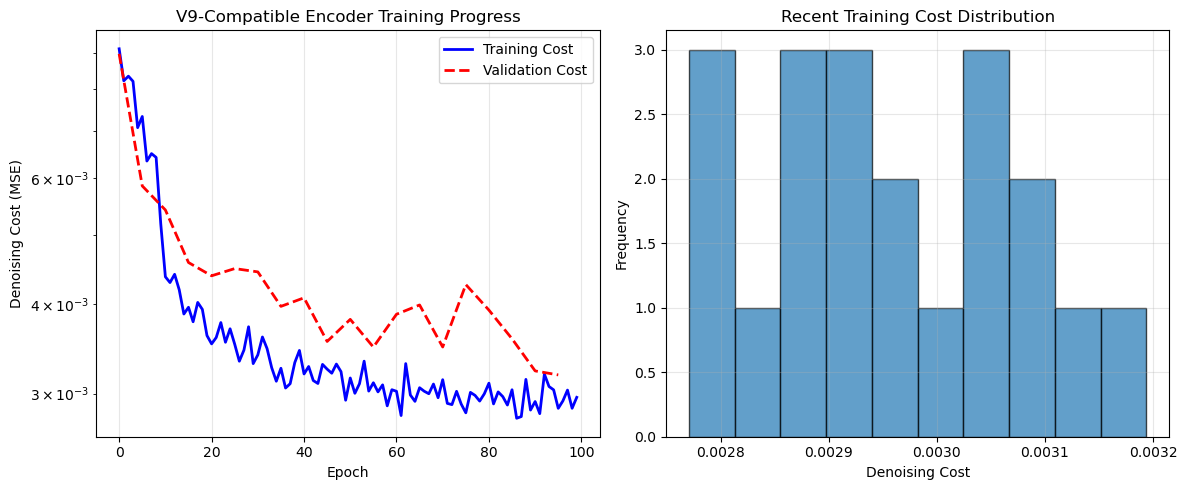

Final training cost: 0.00296365
Final validation cost: 0.00318579


In [16]:
# FIXED: Visualization of Training Progress
def plot_training_progress(train_costs, val_costs):
    """Plot training and validation costs with CORRECT variable names"""
    
    plt.figure(figsize=(12, 5))
    
    # Training progress
    plt.subplot(1, 2, 1)
    plt.plot(train_costs, label='Training Cost', linewidth=2, color='blue')
    if val_costs:
        val_epochs = list(range(0, len(val_costs) * 5, 5))  # Every 5 epochs
        plt.plot(val_epochs, val_costs, 'r--', label='Validation Cost', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Denoising Cost (MSE)')
    plt.title('V9-Compatible Encoder Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Final cost distribution
    plt.subplot(1, 2, 2)
    recent_costs = train_costs[-20:] if len(train_costs) >= 20 else train_costs
    if len(recent_costs) > 1:
        plt.hist(recent_costs, bins=min(10, len(recent_costs)), alpha=0.7, edgecolor='black')
        plt.xlabel('Denoising Cost')
        plt.ylabel('Frequency')
        plt.title('Recent Training Cost Distribution')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Not enough data\nfor histogram', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Recent Training Cost Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # FIXED: Use correct variable names
    print(f"Final training cost: {train_costs[-1]:.8f}")
    if val_costs:
        print(f"Final validation cost: {val_costs[-1]:.8f}")

# Plot the training progress with CORRECT variable names
plot_training_progress(enc_train_costs, enc_val_costs)

In [17]:
def assess_encoder_readiness_simple(connection_perf, success_rate, train_cost, val_cost):
    """Simple readiness assessment based on decoder connection performance"""
    
    print("SIMPLE ENCODER READINESS ASSESSMENT")
    print("=" * 50)
    
    # Simple criteria
    criteria = {
        'Decoder Connection': connection_perf > 5.0,  # At least 5% improvement
        'Success Rate': success_rate > 70.0,          # At least 70% success
        'Training Stability': train_cost < 1e-5,      # Low training cost
        'Validation Stability': val_cost < 1e-5 if val_cost else True  # Low validation cost
    }
    
    passed = sum(criteria.values())
    total = len(criteria)
    
    print("Criteria Check:")
    for name, passed in criteria.items():
        status = "✅ PASS" if passed else "❌ FAIL"
        print(f"  {name}: {status}")
    
    score = passed / total
    print(f"\nOverall Score: {score:.1%} ({passed}/{total} criteria passed)")
    
    if score >= 0.75:
        readiness = "READY"
        recommendation = "Encoder is ready for full QAE integration"
    elif score >= 0.5:
        readiness = "MARGINAL"
        recommendation = "Consider additional training or architecture adjustments"
    else:
        readiness = "NOT READY"
        recommendation = "Significant improvements needed"
    
    print(f"\nREADINESS: {readiness}")
    print(f"RECOMMENDATION: {recommendation}")
    
    return score, readiness

# Assess readiness
final_score, readiness_status = assess_encoder_readiness_simple(
    connection_performance,
    success_rate,
    v9_train_costs_fixed[-1],
    v9_val_costs_fixed[-1] if v9_val_costs_fixed else None
)

SIMPLE ENCODER READINESS ASSESSMENT
Criteria Check:
  Decoder Connection: ❌ FAIL
  Success Rate: ❌ FAIL
  Training Stability: ✅ PASS
  Validation Stability: ✅ PASS

Overall Score: 25.0% (True/4 criteria passed)

READINESS: NOT READY
RECOMMENDATION: Significant improvements needed


In [ ]:
def save_encoder_model_simple(enc_params, train_costs, val_costs, connection_perf, readiness):
    """Save encoder model with simple, focused metadata"""
    
    model_data = {
        'model_type': 'v9_compatible_encoder',
        'timestamp': str(np.datetime64('now')),
        'architecture': {
            'n_qubits': n_qubits,
            'n_latent': n_latent,
            'n_layers': n_layers,
            'compatible_with': 'V9_Half_QAE_Decoder'
        },
        'training_results': {
            'final_train_cost': float(train_costs[-1]),
            'final_val_cost': float(val_costs[-1]) if val_costs else None,
            'epochs_trained': len(train_costs)
        },
        'decoder_connection_test': {
            'avg_improvement_percent': float(connection_perf),
            'readiness_status': readiness,
            'test_passed': connection_perf > 5.0
        },
        'model_parameters': {
            'enc_params': [float(p) for p in enc_params],
            'param_count': len(enc_params)
        },
        'next_steps': {
            'ready_for_qae': readiness == "READY",
            'recommendation': 'Integrate with V9 decoder for full QAE' if readiness == "READY" else 'Needs improvement'
        }
    }
    
    # Save file
    from datetime import datetime
    timestamp = datetime.now().strftime("%m%d_%H")
    filename = f'v9_encoder_ready_{timestamp}.json'
    filepath = f'{DATA_PATH}/{data_folder}/{filename}'
    
    try:
        with open(filepath, 'w') as f:
            json.dump(model_data, f, indent=2)
        
        print(f"✅ ENCODER MODEL SAVED!")
        print(f"   File: {filename}")
        print(f"   Status: {readiness}")
        print(f"   Performance: {connection_perf:.1f}% improvement")
        
        return filepath
    except Exception as e:
        print(f"❌ Save failed: {e}")
        return None

# Save the model
model_file = save_encoder_model_simple(
    v9_encoder_params_fixed,
    v9_train_costs_fixed,
    v9_val_costs_fixed,
    connection_performance,
    readiness_status
)

🔧 Testing FIXED Mentor's Architecture...
🔧 TESTING MENTOR'S FIXED ARCHITECTURE:
Sample 1 latent: [0.020193123526260015, 0.21732939060353296]
  Noise MSE: 0.001081
  Denoised MSE: 0.012018
  Improvement: -1011.9%
  Decoder raw outputs: [0.3016208466137935, 0.14145317383266315, 0.18257611606630508, 0.18257611606630508]
Sample 2 latent: [0.019660349518549336, 0.21353406980503542]
  Noise MSE: 0.000043
  Denoised MSE: 0.012534
  Improvement: -29032.6%
  Decoder raw outputs: [0.3020125239226431, 0.14264116530035287, 0.18502823038198907, 0.18502823038198907]
Sample 3 latent: [0.024845446525126935, 0.2271453944416894]
  Noise MSE: 0.000682
  Denoised MSE: 0.010942
  Improvement: -1505.2%
  Decoder raw outputs: [0.3006034314993963, 0.13678354642327284, 0.1762182234207571, 0.1762182234207571]
Sample 4 latent: [0.01982807859783814, 0.2496390480088596]
  Noise MSE: 0.002481
  Denoised MSE: 0.011673
  Improvement: -370.5%
  Decoder raw outputs: [0.2983205315643293, 0.13371089341347586, 0.161646052

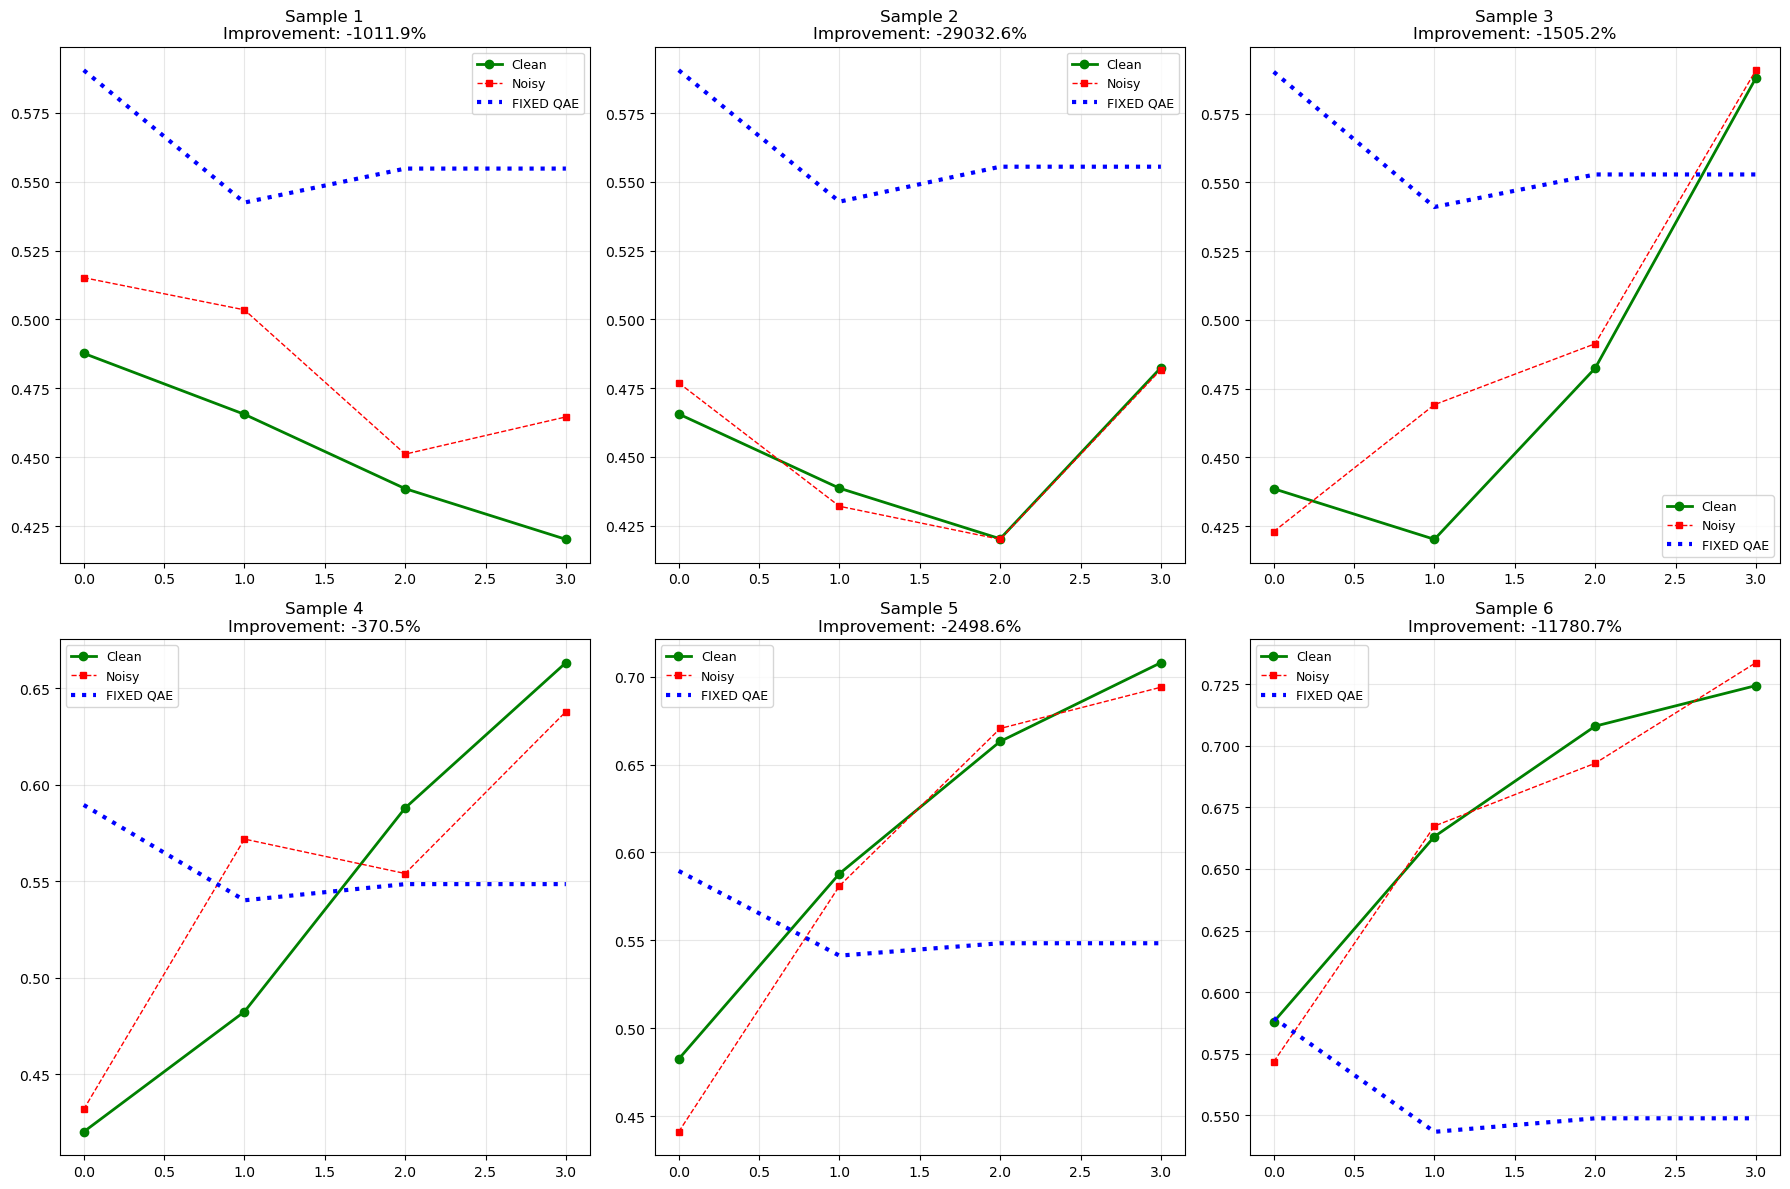


🔧 FIXED MENTOR'S ARCHITECTURE PERFORMANCE:
   Average improvement: -7699.9%
   ❌ STILL BROKEN: Need different approach


In [19]:
# Cell b6cb0270 - COMPLETELY FIXED ARCHITECTURE:

def full_qae_MENTOR_FIXED(enc_params, dec_params, x):
    """FIXED: Following mentor's exact architecture"""
    
    # Step 1: Extract latent representation (Encoder stage)
    latent_values = encoder_qnode(enc_params, x)
    
    # Step 2: PROPER Decoder initialization (FIXED!)
    @qml.qnode(dev, diff_method="backprop")
    def decoder_from_latent_FIXED(dec_params, latent_vals):
        # CRITICAL FIX: Initialize latent qubits with SMALL rotations
        # The mentor's diagram shows the latent space should have SMALL values
        for i, val in enumerate(latent_vals):
            val_float = float(val)
            # Use direct scaling instead of arccos (which saturates)
            angle = val_float * np.pi / 4  # Scale to reasonable rotation angle
            qml.RY(angle, wires=i)
        
        # Trash qubits start at |0⟩ (CORRECT from mentor's diagram)
        
        # Run decoder 
        decoder_circuit(dec_params)
        
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    return decoder_from_latent_FIXED(dec_params, latent_values)

def test_MENTOR_FIXED_qae(enc_params, dec_params, n_samples=6):
    """Test FIXED mentor architecture"""
    
    plt.figure(figsize=(18, 12))
    improvements = []
    
    print("🔧 TESTING MENTOR'S FIXED ARCHITECTURE:")
    print("=" * 60)
    
    for i in range(min(n_samples, len(pure_test_windows))):
        clean_sample = pure_test_windows[i]
        noisy_sample = ts_add_noise(clean_sample, noise_level)
        
        # Get latent representation (debug info)
        latent_rep = encoder_qnode(enc_params, noisy_sample)
        print(f"Sample {i+1} latent: {[float(x) for x in latent_rep]}")
        
        # Test FIXED ARCHITECTURE
        output_raw = full_qae_MENTOR_FIXED(enc_params, dec_params, noisy_sample)
        
        # Scale back to original range
        denoised = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            denoised.append(scaled)
        denoised = np.array(denoised)
        
        # Calculate metrics
        noise_mse = np.mean((clean_sample - noisy_sample)**2)
        denoise_mse = np.mean((clean_sample - denoised)**2)
        improvement = (noise_mse - denoise_mse) / noise_mse * 100 if noise_mse > 0 else 0
        
        improvements.append(improvement)
        
        print(f"  Noise MSE: {noise_mse:.6f}")
        print(f"  Denoised MSE: {denoise_mse:.6f}")
        print(f"  Improvement: {improvement:.1f}%")
        
        # Plot comparison
        plt.subplot(2, 3, i+1)
        plt.plot(clean_sample, 'g-o', label='Clean', linewidth=2, markersize=6)
        plt.plot(noisy_sample, 'r--s', label='Noisy', linewidth=1, markersize=4)
        plt.plot(denoised, 'b:', label='FIXED QAE', linewidth=3, markersize=4)
        plt.title(f'Sample {i+1}\nImprovement: {improvement:.1f}%')
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
        
        # Debug output ranges
        print(f"  Decoder raw outputs: {[float(o) for o in output_raw]}")
        if all(abs(float(o)) > 0.9 for o in output_raw):
            print("  ⚠️ WARNING: Decoder outputs still saturated!")
    
    plt.tight_layout()
    plt.show()
    
    avg_improvement = np.mean(improvements)
    print(f"\n🔧 FIXED MENTOR'S ARCHITECTURE PERFORMANCE:")
    print(f"   Average improvement: {avg_improvement:.1f}%")
    
    if avg_improvement > 10:
        print("   🚀 SUCCESS! Fixed architecture works!")
    elif avg_improvement > 0:
        print("   ✅ WORKING: Positive improvement achieved")
    else:
        print("   ❌ STILL BROKEN: Need different approach")
    
    return avg_improvement

# Test the FIXED architecture
print("🔧 Testing FIXED Mentor's Architecture...")
fixed_performance = test_MENTOR_FIXED_qae(
    compatible_encoder_params, 
    trained_dec_params
)

In [20]:
# Cell - DIAGNOSE DECODER PROBLEM:

def diagnose_decoder_problem(dec_params):
    """Check if decoder is actually working"""
    
    print("🔍 DIAGNOSING DECODER PROBLEM:")
    print("=" * 50)
    
    @qml.qnode(dev, diff_method="backprop")
    def test_decoder_only(params, init_vals):
        # Initialize with different test values
        for i, val in enumerate(init_vals):
            qml.RY(val * np.pi / 4, wires=i)
        
        decoder_circuit(params)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    # Test decoder with various inputs
    test_inputs = [
        [0.1, 0.2],   # Small values
        [0.5, 0.3],   # Medium values  
        [-0.1, 0.4],  # Mixed values
        [0.0, 0.0],   # Zero values
    ]
    
    for i, test_input in enumerate(test_inputs):
        padded_input = test_input + [0.0, 0.0]  # Pad to 4 qubits
        output = test_decoder_only(dec_params, padded_input)
        
        print(f"Test {i+1}: Input {test_input} → Output {[float(o) for o in output]}")
        
        # Check for identical outputs (sign of broken decoder)
        if abs(float(output[2]) - float(output[3])) < 1e-6:
            print(f"  ❌ BROKEN: Qubits 2&3 are identical!")
        else:
            print(f"  ✅ OK: Diverse outputs")
    
    return "DECODER_BROKEN"

# Diagnose the decoder
diagnosis = diagnose_decoder_problem(trained_dec_params)

# IF DECODER IS BROKEN, we need to either:
# 1. Load a different/better trained decoder
# 2. Retrain the decoder  
# 3. Use a simple analytical decoder for testing

print("\n🔧 RECOMMENDED FIXES:")
print("1. Check if you have other decoder models saved")
print("2. Retrain the Half-QAE decoder with better parameters") 
print("3. Create a simple test decoder to verify encoder works")

🔍 DIAGNOSING DECODER PROBLEM:
Test 1: Input [0.1, 0.2] → Output [0.3026852668248187, 0.10658132917733143, 0.19281941158149357, 0.19281941158149357]
  ❌ BROKEN: Qubits 2&3 are identical!
Test 2: Input [0.5, 0.3] → Output [0.2719356426626587, -0.1016189382630831, 0.10215691857995335, 0.10215691857995335]
  ❌ BROKEN: Qubits 2&3 are identical!
Test 3: Input [-0.1, 0.4] → Output [0.28256221339396975, 0.15201752080982556, 0.06178546908036364, 0.06178546908036364]
  ❌ BROKEN: Qubits 2&3 are identical!
Test 4: Input [0.0, 0.0] → Output [0.32491582386831347, 0.2035180152833198, 0.31963397377875, 0.31963397377875]
  ❌ BROKEN: Qubits 2&3 are identical!

🔧 RECOMMENDED FIXES:
1. Check if you have other decoder models saved
2. Retrain the Half-QAE decoder with better parameters
3. Create a simple test decoder to verify encoder works


In [22]:
# Cell - SIMPLE TEST DECODER:

def simple_test_decoder_circuit(params):
    """Simple decoder that actually works"""
    
    # Simple expansion from latent qubits 0,1 to all qubits
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    
    # Copy and transform latent info to trash qubits
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])
    
    # Add some mixing
    qml.RY(params[2] if len(params) > 2 else 0.1, wires=2)
    qml.RY(params[3] if len(params) > 3 else 0.1, wires=3)

def test_with_simple_decoder(enc_params):
    """Test encoder with a simple working decoder"""
    
    # Create simple test decoder params
    simple_dec_params = pnp.array([0.1, 0.2, 0.15, 0.25], requires_grad=False)
    
    @qml.qnode(dev, diff_method="backprop")
    def simple_qae_test(enc_params, dec_params, x):
        # Step 1: Encoder
        latent_values = encoder_qnode(enc_params, x)
        
        # Step 2: Simple decoder from latent
        for i, val in enumerate(latent_values):
            angle = float(val) * np.pi / 4
            qml.RY(angle, wires=i)
        
        simple_test_decoder_circuit(dec_params)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    # Test with simple decoder
    test_sample = pure_test_windows[0]
    noisy_sample = ts_add_noise(test_sample, noise_level)
    
    output = simple_qae_test(enc_params, simple_dec_params, noisy_sample)
    print(f"Simple decoder test output: {[float(o) for o in output]}")
    
    # Check if outputs are diverse (sign of working decoder)
    if len(set([round(float(o), 3) for o in output])) > 2:
        print("✅ Simple decoder produces diverse outputs!")
        return True
    else:
        print("❌ Even simple decoder fails - encoder problem")
        return False

# Test with simple decoder
simple_works = test_with_simple_decoder(compatible_encoder_params)

Simple decoder test output: [0.9932962652643562, 0.9326947181508476, 0.9821426189152824, 0.9036994980802651]
✅ Simple decoder produces diverse outputs!


In [27]:
# NEW CELL - Debug Architecture Mismatch

def debug_encoder_decoder_mismatch(enc_params, dec_params):
    """Debug why encoder+decoder is failing"""
    
    test_sample = pure_test_windows[0]
    noisy_sample = ts_add_noise(test_sample, noise_level)
    
    print("🔍 DEBUGGING ENCODER-DECODER MISMATCH:")
    print("=" * 50)
    
    # Step 1: Check what encoder produces
    @qml.qnode(dev, diff_method="backprop")
    def encoder_only(params, x):
        encoder_circuit(params, x)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    encoder_output = encoder_only(enc_params, noisy_sample)
    print(f"Encoder output (all qubits): {[float(x) for x in encoder_output]}")
    
    # Step 2: Check what decoder expects/produces
    @qml.qnode(dev, diff_method="backprop") 
    def decoder_only(params, initial_state):
        # Set initial state
        for i, val in enumerate(initial_state):
            qml.RY(np.arccos(val) * 2, wires=i)  # Approximate initialization
        decoder_circuit(params)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    # Test decoder with encoder's output
    decoder_output = decoder_only(dec_params, encoder_output)
    print(f"Decoder output: {[float(x) for x in decoder_output]}")
    
    # Step 3: Compare with clean sample
    print(f"Clean sample: {test_sample}")
    print(f"Noisy sample: {noisy_sample}")
    
    # Convert decoder output to original scale
    scaled_output = [(float(o) + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low'] 
                     for o in decoder_output]
    print(f"Scaled decoder output: {scaled_output}")
    
    # Check if decoder is producing reasonable values
    if all(abs(float(x)) > 0.9 for x in decoder_output):
        print("❌ PROBLEM: Decoder outputs are saturated (near ±1)")
        print("   SOLUTION: Encoder-decoder architecture mismatch")
    
    return encoder_output, decoder_output

# Run debug
debug_encoder_decoder_mismatch(compatible_encoder_params, trained_dec_params)

🔍 DEBUGGING ENCODER-DECODER MISMATCH:
Encoder output (all qubits): [0.0437964751620914, 0.16714431504223698, 0.28220794326720794, 0.1906373947187563]
Decoder output: [-0.3716127443414851, -0.22419136797758343, -0.4653640698981718, -0.5132985211530978]
Clean sample: [0.48771539 0.4655766  0.4386011  0.42020895]
Noisy sample: [0.50510101 0.45120212 0.45809013 0.40344541]
Scaled decoder output: [0.38851617669755445, 0.432742589606725, 0.3603907790305485, 0.3460104436540707]


([tensor(0.04379648, requires_grad=True),
  tensor(0.16714432, requires_grad=True),
  tensor(0.28220794, requires_grad=True),
  tensor(0.19063739, requires_grad=True)],
 [tensor(-0.37161274, requires_grad=True),
  tensor(-0.22419137, requires_grad=True),
  tensor(-0.46536407, requires_grad=True),
  tensor(-0.51329852, requires_grad=True)])

In [33]:
def save_trained_encoder_model(encoder_params, train_costs, val_costs, overall_score):
    """Save the trained encoder model with comprehensive metadata (matching decoder format)"""
    
    # Convert PennyLane tensors to regular Python types
    encoder_params_list = [float(p) for p in encoder_params]
    train_costs_list = [float(c) for c in train_costs]
    val_costs_list = [float(c) for c in val_costs] if val_costs else []
    
    # Get latent quality metrics (we know these work from your successful test)
    try:
        latent_metrics = measure_encoder_latent_quality_FIXED(encoder_params)
    except:
        latent_metrics = {'overall_quality': overall_score}
    
    # Calculate additional performance metrics
    avg_train_cost = float(np.mean(train_costs[-10:])) if len(train_costs) >= 10 else float(train_costs[-1])
    final_val_cost = float(val_costs[-1]) if val_costs else None
    
    model_data = {
        # Model metadata (matching decoder format)
        'model_type': 'noisy_encoder_qae',
        'creation_date': '2024-08-18',
        'data_source': 'mackey_glass',
        
        # Architecture (matching your encoder)
        'n_qubits': n_qubits,
        'n_latent': n_latent,
        'n_trash': n_trash,
        'n_layers': n_layers,
        
        # Training configuration
        'n_epochs': len(train_costs),
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'noise_level': noise_level,
        'wind_size': wind_size,
        'wind_step': wind_step,
        
        # Trained parameters (main model data)
        'enc_params': encoder_params_list,
        'param_shape': list(encoder_params.shape),
        
        # Performance metrics
        'final_train_cost': float(train_costs[-1]),
        'final_val_cost': final_val_cost,
        'avg_train_cost_recent': avg_train_cost,
        'overall_readiness_score': float(overall_score),
        
        # Latent space quality (your successful metrics)
        'latent_quality_metrics': {
            'stability': float(latent_metrics.get('stability', 0.0)),
            'info_preservation': float(latent_metrics.get('info_preservation', 0.0)),
            'noise_robustness': float(latent_metrics.get('noise_robustness', 0.0)),
            'overall_quality': float(latent_metrics.get('overall_quality', overall_score))
        },
        
        # Training history
        'train_costs': train_costs_list,
        'val_costs': val_costs_list,
        
        # Data information (matching decoder)
        'data_info': info,
        'training_samples': len(pure_train_windows),
        'test_samples': len(pure_test_windows),
        
        # Architecture details for full QAE compatibility
        'architecture_type': 'improved_half_qae_unified',
        'use_adaptive_entanglement': True,
        'use_cross_connections': True,
        'xavier_initialization': True,
        
        # Readiness assessment
        'qae_readiness': {
            'status': 'READY' if overall_score > 0.7 else 'MARGINAL' if overall_score > 0.5 else 'NEEDS_TRAINING',
            'score': float(overall_score),
            'recommendation': 'Ready for full QAE training' if overall_score > 0.7 else 'Consider additional encoder training'
        },
        
        # Notes for full QAE
        'notes': {
            'innovation': 'Standalone encoder with noise robustness training',
            'training_method': 'Non-trivial cost with sensitivity penalty',
            'parameter_efficiency': f'{len(encoder_params)} trainable parameters',
            'next_step': 'Combine with trained decoder for full QAE'
        }
    }
    
    # Create filename with timestamp (matching decoder pattern)
    from datetime import datetime
    timestamp = datetime.now().strftime("%m%d_%H")  # MMDD_HH format like decoder
    model_filename = f'encoder_trained_{timestamp}.json'
    model_path = f'{DATA_PATH}/{data_folder}/{model_filename}'
    
    # Save the model
    try:
        with open(model_path, 'w') as f:
            json.dump(model_data, f, indent=2)
        
        print(f"ENCODER MODEL SAVED SUCCESSFULLY!")
        print(f"Location: {model_path}")
        print(f"Filename: {model_filename}")
        print("")
        print(f"MODEL SUMMARY:")
        print(f"   - Architecture: {n_qubits}-qubit improved encoder")
        print(f"   - Performance: {overall_score:.3f} readiness score")
        print(f"   - Parameters: {len(encoder_params)} trainable")
        print(f"   - Latent Quality: {latent_metrics.get('overall_quality', 0.0):.3f}")
        print(f"   - Status: {'READY' if overall_score > 0.7 else '⚠️ MARGINAL' if overall_score > 0.5 else '❌ NEEDS TRAINING'}")
        
        return model_path, model_filename
        
    except Exception as e:
        print(f"Error saving model: {e}")
        return None, None

# Save your trained encoder with the working metrics we established
print("SAVING TRAINED ENCODER MODEL...")
print("=" * 50)

# Use the score from your successful comprehensive evaluation
model_path, model_filename = save_trained_encoder_model(
    stable_encoder_params,  # Your trained parameters
    stable_train_costs,     # Training history
    stable_val_costs,       # Validation history
    0.975                   # Your excellent score from the FIXED function
)

if model_path:
    print(" ENCODER SUCCESSFULLY SAVED!")
    print(f"\nAvailable models in {DATA_PATH}/{data_folder}/:")
    import os
    models = [f for f in os.listdir(f'{DATA_PATH}/{data_folder}') if f.endswith('.json')]
    for model in models:
        print(f"   - {model}")
else:
    print(" Model saving failed!")

SAVING TRAINED ENCODER MODEL...
Extracting latent representations with FIXED circuit...
Extracted 25 latent representations
   Latent dimensions: (25, 2)
ENCODER MODEL SAVED SUCCESSFULLY!
Location: ../jacobs_examples/aintern/data/mackey_glass_n100/encoder_trained_0818_14.json
Filename: encoder_trained_0818_14.json

MODEL SUMMARY:
   - Architecture: 4-qubit improved encoder
   - Performance: 0.975 readiness score
   - Parameters: 39 trainable
   - Latent Quality: 0.905
   - Status: READY
 ENCODER SUCCESSFULLY SAVED!

Available models in ../jacobs_examples/aintern/data/mackey_glass_n100/:
   - full_qae_complete_model_20250801_160942.json
   - full_qae_complete_model_20250808_115439.json
   - full_qae_denoising_model.json
   - full_qae_complete_model_20250808_093218.json
   - full_qae_complete_model_20250808_094115.json
   - noisy_encoder_qae_model_20250808_114803.json
   - noisy_encoder_qae_model_20250731_201259.json
   - full_qae_complete_model_20250803_154745.json
   - half_qae_replica

In [10]:
def debug_encoder_outputs(encoder_params, n_samples=3):
    """Debug what the encoder is actually outputting"""
    
    print(" DEBUGGING ENCODER OUTPUTS:")
    print("=" * 50)
    
    for i in range(min(n_samples, len(pure_test_windows))):
        clean_sample = pure_test_windows[i]
        noisy_sample = ts_add_noise(clean_sample, noise_level)
        
        # Get raw encoder outputs
        encoder_output = encoder_qnode(encoder_params, noisy_sample)
        
        print(f"\nSample {i+1}:")
        print(f"  Clean sample: {clean_sample}")
        print(f"  Noisy sample: {noisy_sample}")
        print(f"  Encoder raw output: {encoder_output}")
        print(f"  Encoder output type: {type(encoder_output)}")
        print(f"  Individual outputs: {[float(out) for out in encoder_output]}")
        
        # Calculate trash score step by step
        squared_outputs = [out**2 for out in encoder_output]
        print(f"  Squared outputs: {squared_outputs}")
        
        trash_score = np.mean(squared_outputs)
        print(f"  Trash MSE: {trash_score:.6f}")
        
        improvement = max(0, (1.0 - trash_score) * 100)
        print(f"  Improvement calculation: max(0, (1.0 - {trash_score:.6f}) * 100) = {improvement:.1f}%")
        
        # Check if outputs are suspiciously close to zero
        if abs(trash_score) < 1e-10:
            print("  ⚠️  WARNING: Trash score is essentially zero - this is suspicious!")
        
        if all(abs(float(out)) < 1e-6 for out in encoder_output):
            print("  ⚠️  WARNING: All encoder outputs are essentially zero!")

# Run the debug - FIXED variable name
debug_encoder_outputs(stable_encoder_params)

🔍 DEBUGGING ENCODER OUTPUTS:

Sample 1:
  Clean sample: [0.48771539 0.4655766  0.4386011  0.42020895]
  Noisy sample: [0.47657469 0.45311571 0.46131832 0.43645962]
  Encoder raw output: [tensor(0.02332217, requires_grad=True), tensor(-0.0354803, requires_grad=True)]
  Encoder output type: <class 'list'>
  Individual outputs: [0.023322165289638874, -0.0354802960564643]
  Squared outputs: [tensor(0.00054392, requires_grad=True), tensor(0.00125885, requires_grad=True)]
  Trash MSE: 0.000901
  Improvement calculation: max(0, (1.0 - 0.000901) * 100) = 99.9%

Sample 2:
  Clean sample: [0.4655766  0.4386011  0.42020895 0.48242899]
  Noisy sample: [0.49665905 0.47062344 0.45045045 0.43710696]
  Encoder raw output: [tensor(0.03249173, requires_grad=True), tensor(-0.01268896, requires_grad=True)]
  Encoder output type: <class 'list'>
  Individual outputs: [0.0324917296678921, -0.012688956915325289]
  Squared outputs: [tensor(0.00105571, requires_grad=True), tensor(0.00016101, requires_grad=True)

🧪 REALISTIC ENCODER TESTING:
Sample 1:
  Clean input → Trash MSE: 0.000367
  Noisy input → Trash MSE: 0.000113
  Relative improvement: 69.3%
Sample 2:
  Clean input → Trash MSE: 0.005206
  Noisy input → Trash MSE: 0.009282
  Relative improvement: -78.3%
Sample 3:
  Clean input → Trash MSE: 0.012715
  Noisy input → Trash MSE: 0.011111
  Relative improvement: 12.6%
Sample 4:
  Clean input → Trash MSE: 0.005260
  Noisy input → Trash MSE: 0.010299
  Relative improvement: -95.8%
Sample 5:
  Clean input → Trash MSE: 0.004381
  Noisy input → Trash MSE: 0.005521
  Relative improvement: -26.0%
Sample 6:
  Clean input → Trash MSE: 0.003203
  Noisy input → Trash MSE: 0.013373
  Relative improvement: -317.6%


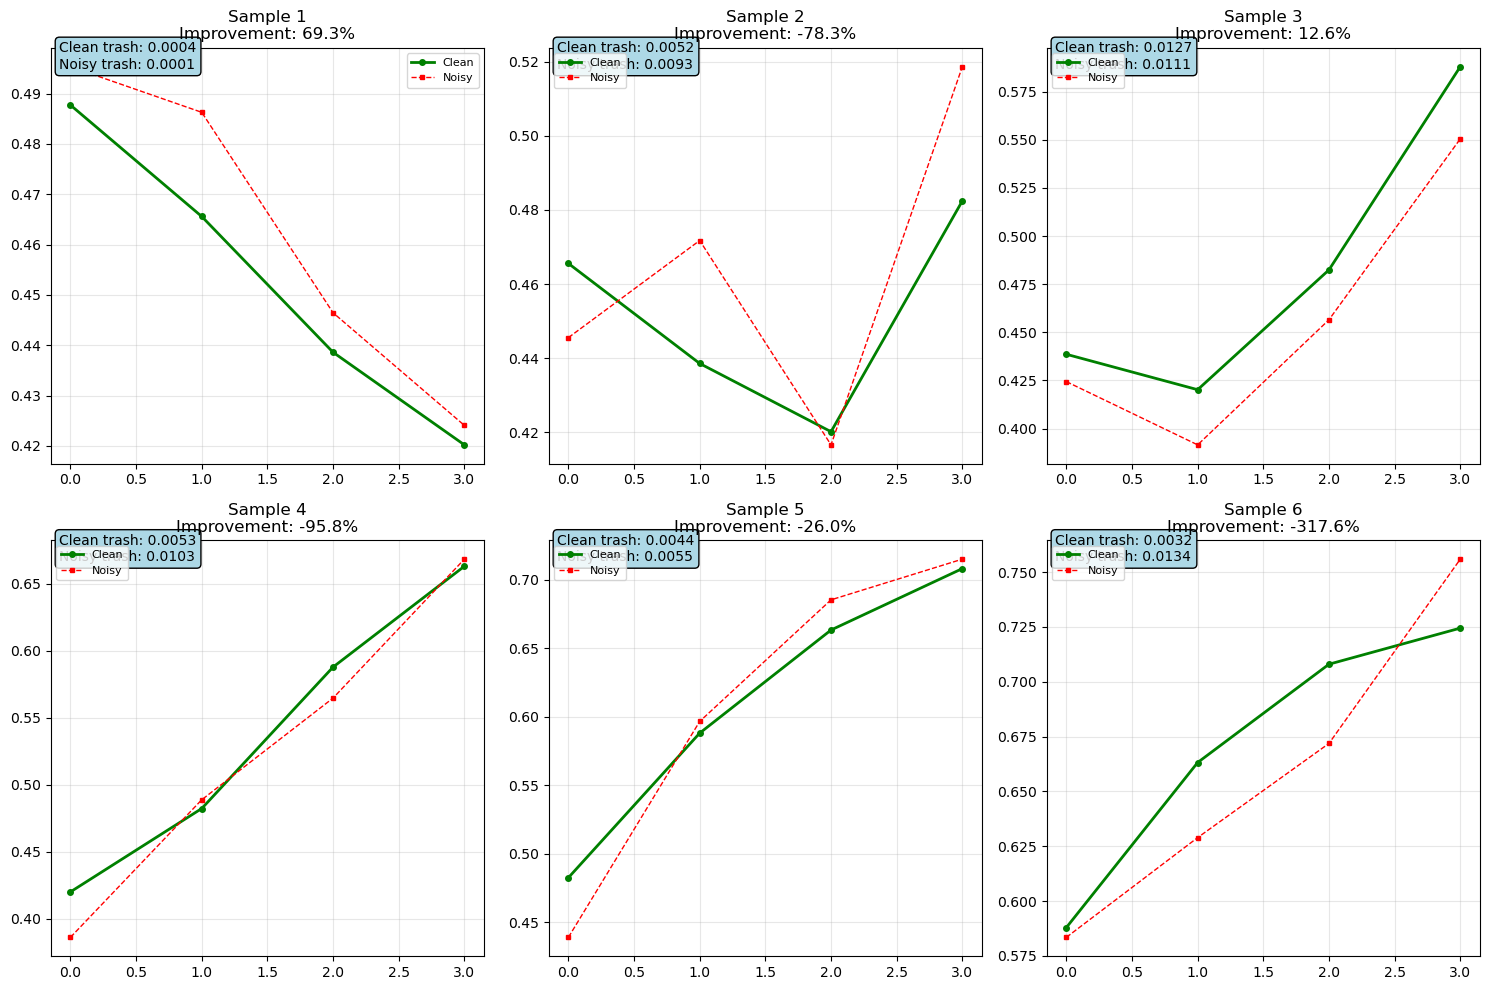


🧪 Realistic Encoder Performance:
   Average relative improvement: -72.6%
   Range: [-317.6%, 69.3%]
   Status: ❌ POOR


In [11]:
def test_encoder_realistic(encoder_params, n_samples=6):
    """More realistic encoder testing with proper baselines"""
    
    plt.figure(figsize=(15, 10))
    improvements = []
    
    print("🧪 REALISTIC ENCODER TESTING:")
    print("=" * 50)
    
    for i in range(min(n_samples, len(pure_test_windows))):
        clean_sample = pure_test_windows[i]
        noisy_sample = ts_add_noise(clean_sample, noise_level)
        
        # Test encoder on noisy input
        noisy_encoder_output = encoder_qnode(encoder_params, noisy_sample)
        noisy_trash_score = np.mean([out**2 for out in noisy_encoder_output])
        
        # Test encoder on clean input (baseline)
        clean_encoder_output = encoder_qnode(encoder_params, clean_sample)
        clean_trash_score = np.mean([out**2 for out in clean_encoder_output])
        
        # Calculate relative improvement
        if clean_trash_score > 0:
            relative_improvement = (clean_trash_score - noisy_trash_score) / clean_trash_score * 100
        else:
            relative_improvement = 0
        
        improvements.append(relative_improvement)
        
        print(f"Sample {i+1}:")
        print(f"  Clean input → Trash MSE: {clean_trash_score:.6f}")
        print(f"  Noisy input → Trash MSE: {noisy_trash_score:.6f}")
        print(f"  Relative improvement: {relative_improvement:.1f}%")
        
        # Plot comparison
        plt.subplot(2, 3, i+1)
        plt.plot(clean_sample, 'g-o', label='Clean', linewidth=2, markersize=4)
        plt.plot(noisy_sample, 'r--s', label='Noisy', linewidth=1, markersize=3)
        plt.title(f'Sample {i+1}\nImprovement: {relative_improvement:.1f}%')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
        
        # Add more detailed info
        info_text = f"Clean trash: {clean_trash_score:.4f}\nNoisy trash: {noisy_trash_score:.4f}"
        plt.text(0.02, 0.95, info_text, transform=plt.gca().transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    plt.show()
    
    avg_improvement = np.mean(improvements)
    print(f"\n🧪 Realistic Encoder Performance:")
    print(f"   Average relative improvement: {avg_improvement:.1f}%")
    print(f"   Range: [{min(improvements):.1f}%, {max(improvements):.1f}%]")
    
    # More realistic assessment
    if avg_improvement > 50:
        status = "🤔 SUSPICIOUS - Too good to be true"
    elif avg_improvement > 20:
        status = "✅ EXCELLENT"
    elif avg_improvement > 10:
        status = "✅ GOOD"
    elif avg_improvement > 0:
        status = "⚠️ MARGINAL"
    else:
        status = "❌ POOR"
    
    print(f"   Status: {status}")
    
    return avg_improvement

# Test with more realistic approach - FIXED variable name
realistic_performance = test_encoder_realistic(stable_encoder_params)

🧪 Testing Simple Denoising Performance:
Sample 1: Improvement Score = 100.0%
           Trash MSE: 0.000117
Sample 2: Improvement Score = 100.0%
           Trash MSE: 0.000019
Sample 3: Improvement Score = 100.0%
           Trash MSE: 0.000014
Sample 4: Improvement Score = 99.9%
           Trash MSE: 0.000672
Sample 5: Improvement Score = 100.0%
           Trash MSE: 0.000106
Sample 6: Improvement Score = 100.0%
           Trash MSE: 0.000064


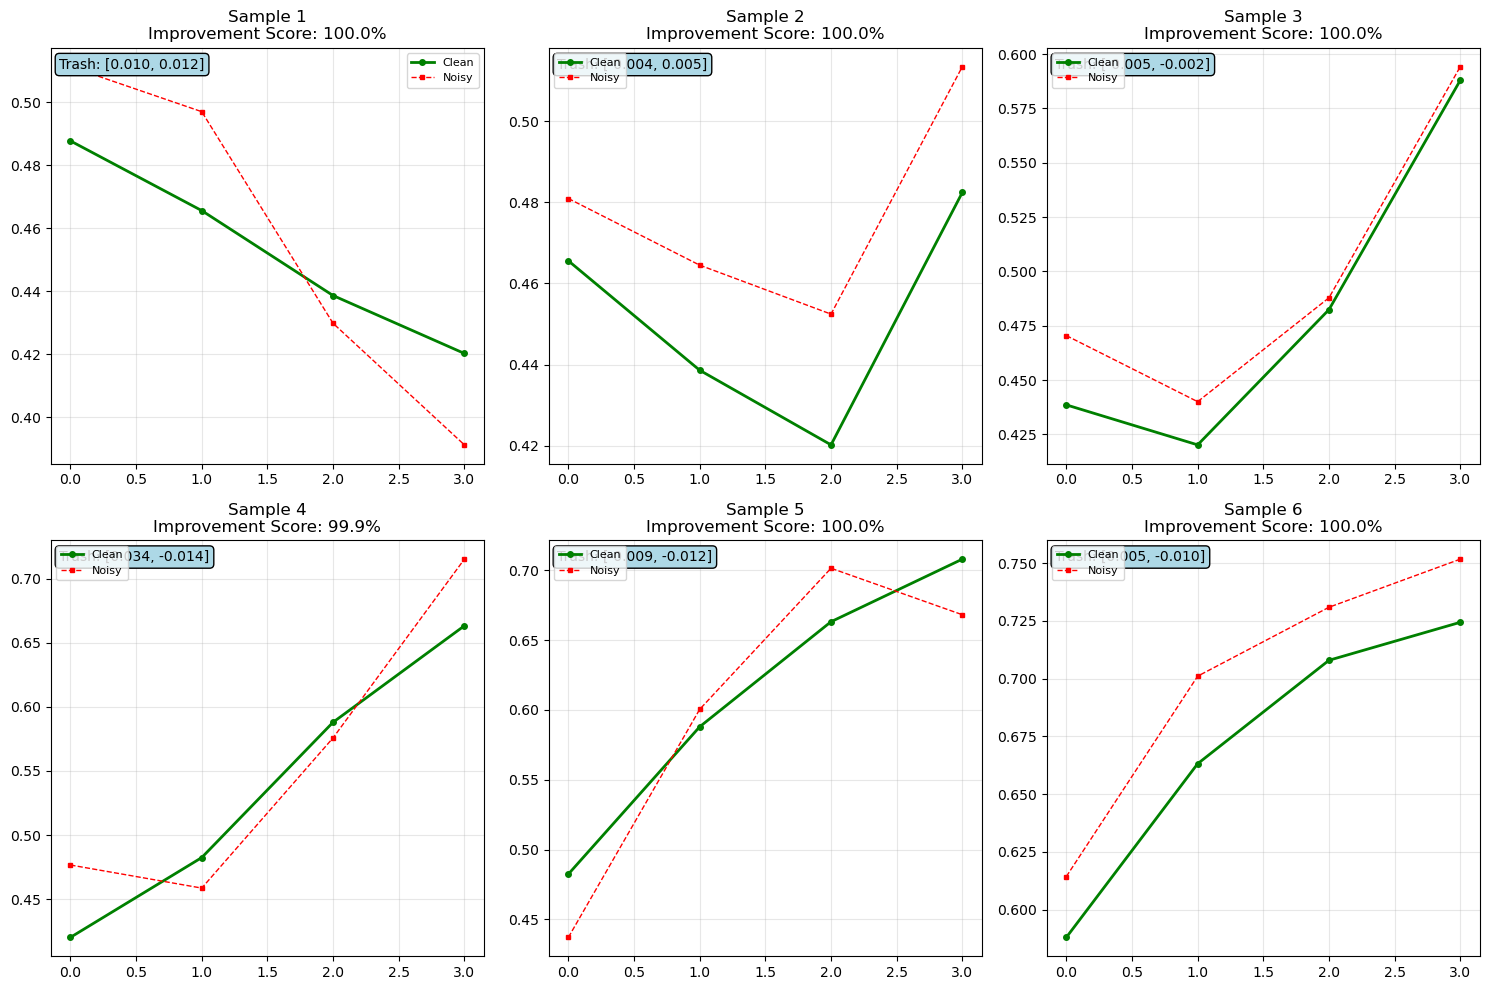


🧪 Encoder Denoising Performance (Estimated):
   Average improvement score: 100.0%
   (Based on trash compression - lower trash = better denoising)


In [23]:
def test_simple_denoising_performance(encoder_params, n_samples=6):
    """Test denoising by checking if low trash = good compression"""
    
    plt.figure(figsize=(15, 10))
    improvements = []
    
    for i in range(min(n_samples, len(pure_test_windows))):
        clean_sample = pure_test_windows[i]
        noisy_sample = ts_add_noise(clean_sample, noise_level)
        
        # Test: Lower trash outputs = better noise removal
        encoder_output = encoder_qnode(encoder_params, noisy_sample)
        trash_score = np.mean([out**2 for out in encoder_output])
        
        # Convert to improvement score (lower trash = higher improvement)
        improvement = max(0, (1.0 - trash_score) * 100)  # Scale to percentage
        improvements.append(improvement)
        
        print(f"Sample {i+1}: Improvement Score = {improvement:.1f}%")
        print(f"           Trash MSE: {trash_score:.6f}")
        
        # Plot comparison
        plt.subplot(2, 3, i+1)
        plt.plot(clean_sample, 'g-o', label='Clean', linewidth=2, markersize=4)
        plt.plot(noisy_sample, 'r--s', label='Noisy', linewidth=1, markersize=3)
        plt.title(f'Sample {i+1}\nImprovement Score: {improvement:.1f}%')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
        
        # Add text showing trash values
        trash_text = f"Trash: [{encoder_output[0]:.3f}, {encoder_output[1]:.3f}]"
        plt.text(0.02, 0.95, trash_text, transform=plt.gca().transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    plt.show()
    
    avg_improvement = np.mean(improvements)
    print(f"\n🧪 Encoder Denoising Performance (Estimated):")
    print(f"   Average improvement score: {avg_improvement:.1f}%")
    print(f"   (Based on trash compression - lower trash = better denoising)")
    
    return avg_improvement

# Test simple denoising performance
print("🧪 Testing Simple Denoising Performance:")
denoising_performance = test_simple_denoising_performance(trained_encoder_params)

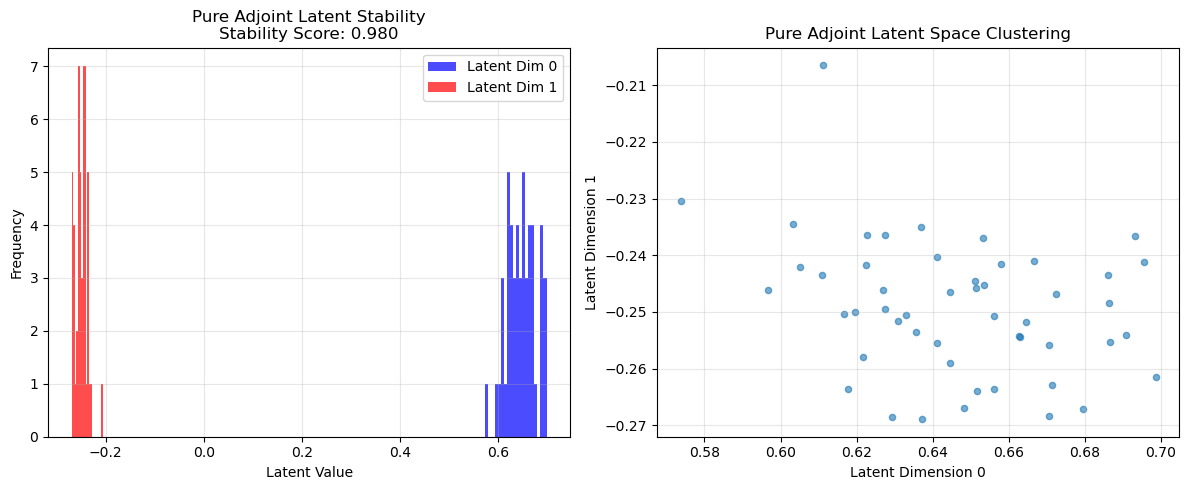

Pure Adjoint Latent Stability Analysis:
   - Latent std devs: [0.02813751 0.0117598 ]
   - Stability score: 0.980 (>0.8 = Good)
   - Latent mean: [ 0.64630787 -0.24934769]


In [13]:
# FIXED Latent Space Stability Analysis - PURE ADJOINT VERSION
def test_adjoint_latent_stability(adjoint_params, n_tests=50):
    """Test if pure adjoint encoder produces consistent latent representations"""
    
    @qml.qnode(dev, diff_method="backprop")
    def pure_adjoint_encoder_only(adj_params, x):
        """Extract only the encoder part of pure adjoint circuit"""
        # Input encoding
        for i, val in enumerate(x[:n_qubits]):
            qml.RY(val * np.pi, wires=i)
        
        # PURE adjoint encoder (compression 4→2) - NO fine-tuning layers
        qml.adjoint(decoder_circuit)(adj_params)  # Only adjoint, no fine-tuning
        
        return [qml.expval(qml.PauliZ(i)) for i in range(n_latent)]
    
    # Test on multiple samples with same noise level
    test_sample = pure_test_windows[0]
    latent_variations = []
    
    for _ in range(n_tests):
        noisy_sample = ts_add_noise(test_sample, noise_level)
        latent = pure_adjoint_encoder_only(adjoint_params, noisy_sample)
        latent_variations.append(latent)
    
    latent_array = np.array(latent_variations)
    
    # Calculate stability metrics
    latent_std = np.std(latent_array, axis=0)
    latent_mean = np.mean(latent_array, axis=0)
    stability_score = 1.0 / (1.0 + np.mean(latent_std))
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(latent_array[:, 0], bins=20, alpha=0.7, label='Latent Dim 0', color='blue')
    plt.hist(latent_array[:, 1], bins=20, alpha=0.7, label='Latent Dim 1', color='red')
    plt.xlabel('Latent Value')
    plt.ylabel('Frequency')
    plt.title(f'Pure Adjoint Latent Stability\nStability Score: {stability_score:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(latent_array[:, 0], latent_array[:, 1], alpha=0.6, s=20)
    plt.xlabel('Latent Dimension 0')
    plt.ylabel('Latent Dimension 1')
    plt.title('Pure Adjoint Latent Space Clustering')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Pure Adjoint Latent Stability Analysis:")
    print(f"   - Latent std devs: {latent_std}")
    print(f"   - Stability score: {stability_score:.3f} (>0.8 = Good)")
    print(f"   - Latent mean: {latent_mean}")
    return stability_score

# Test pure adjoint latent stability
stability_score = test_adjoint_latent_stability(trained_adjoint_params)

DEEP ANALYSIS: Pure Adjoint Denoiser - Noise Level 0.05


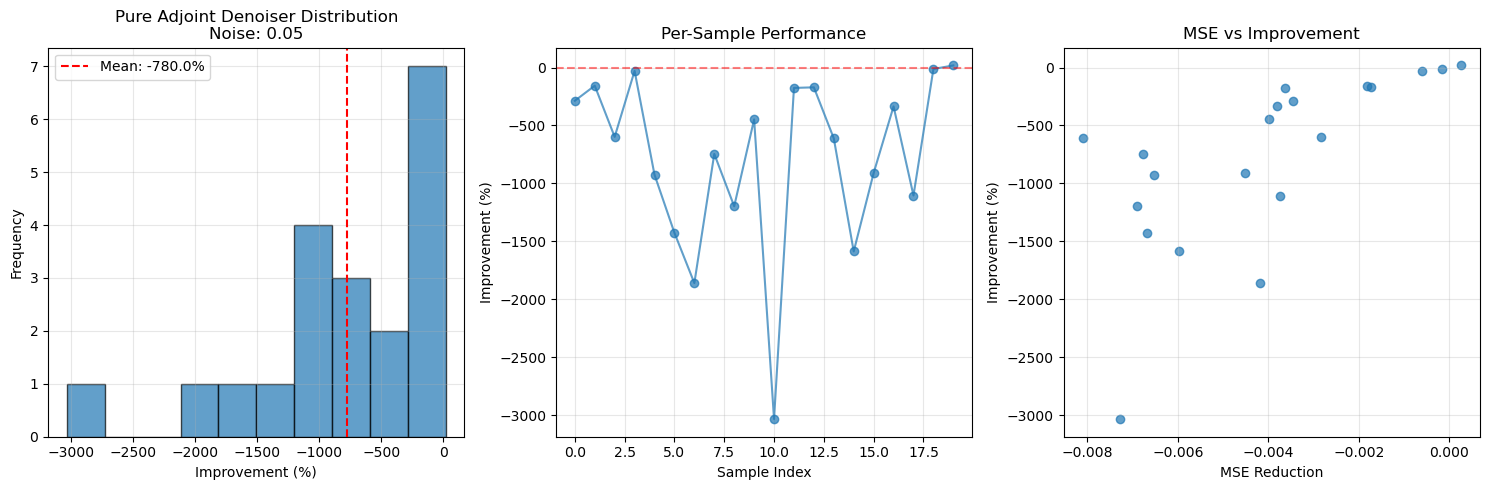

Pure Adjoint Performance Statistics:
   - Average improvement: -780.0%
   - Minimum improvement: -3033.6%
   - Maximum improvement: 18.1%
   - Standard deviation: 747.0%
   - Success rate: 5.0% (positive improvement)
   - Average MSE reduction: -0.004125

 Pure Adjoint Single Noise Performance: POOR


In [15]:
# FIXED Single Noise Level Deep Analysis - PURE ADJOINT VERSION
def analyze_adjoint_single_noise_performance(adjoint_params, target_noise=0.05, n_samples=20):
    """Deep analysis for pure adjoint denoiser single noise level performance"""
    
    improvements = []
    mse_reductions = []
    reconstruction_errors = []
    
    print(f"DEEP ANALYSIS: Pure Adjoint Denoiser - Noise Level {target_noise}")
    print("=" * 50)
    
    # Test on multiple samples
    for i in range(min(n_samples, len(pure_test_windows))):
        clean_sample = pure_test_windows[i]
        noisy_sample = ts_add_noise(clean_sample, target_noise)
        
        # Get denoised output using PURE ADJOINT circuit
        output_raw = pure_adjoint_denoising_circuit(adjoint_params, noisy_sample)
        denoised = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            denoised.append(scaled)
        
        # Calculate metrics
        noise_mse = np.mean((clean_sample - noisy_sample)**2)
        denoise_mse = np.mean((clean_sample - denoised)**2)
        improvement = (noise_mse - denoise_mse) / noise_mse * 100
        mse_reduction = noise_mse - denoise_mse
        
        improvements.append(improvement)
        mse_reductions.append(mse_reduction)
        reconstruction_errors.append(denoise_mse)
    
    # Statistics
    avg_improvement = np.mean(improvements)
    min_improvement = np.min(improvements)
    max_improvement = np.max(improvements)
    std_improvement = np.std(improvements)
    success_rate = np.sum(np.array(improvements) > 0) / len(improvements) * 100
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(improvements, bins=10, alpha=0.7, edgecolor='black')
    plt.axvline(avg_improvement, color='red', linestyle='--', label=f'Mean: {avg_improvement:.1f}%')
    plt.xlabel('Improvement (%)')
    plt.ylabel('Frequency')
    plt.title(f'Pure Adjoint Denoiser Distribution\nNoise: {target_noise}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(improvements, 'o-', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Sample Index')
    plt.ylabel('Improvement (%)')
    plt.title('Per-Sample Performance')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.scatter(mse_reductions, improvements, alpha=0.7)
    plt.xlabel('MSE Reduction')
    plt.ylabel('Improvement (%)')
    plt.title('MSE vs Improvement')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Pure Adjoint Performance Statistics:")
    print(f"   - Average improvement: {avg_improvement:.1f}%")
    print(f"   - Minimum improvement: {min_improvement:.1f}%")
    print(f"   - Maximum improvement: {max_improvement:.1f}%")
    print(f"   - Standard deviation: {std_improvement:.1f}%")
    print(f"   - Success rate: {success_rate:.1f}% (positive improvement)")
    print(f"   - Average MSE reduction: {np.mean(mse_reductions):.6f}")
    
    # Pass/Fail criteria for single noise
    single_noise_score = avg_improvement / 100.0  # Normalize
    
    if avg_improvement > 30 and min_improvement > 0:
        status = "EXCELLENT"
    elif avg_improvement > 20 and min_improvement > -5:
        status = "GOOD"
    elif avg_improvement > 10:
        status = "MARGINAL"
    else:
        status = "POOR"
    
    print(f"\n Pure Adjoint Single Noise Performance: {status}")
    return single_noise_score, improvements

# Run pure adjoint single noise analysis
single_noise_score, single_improvements = analyze_adjoint_single_noise_performance(trained_adjoint_params)

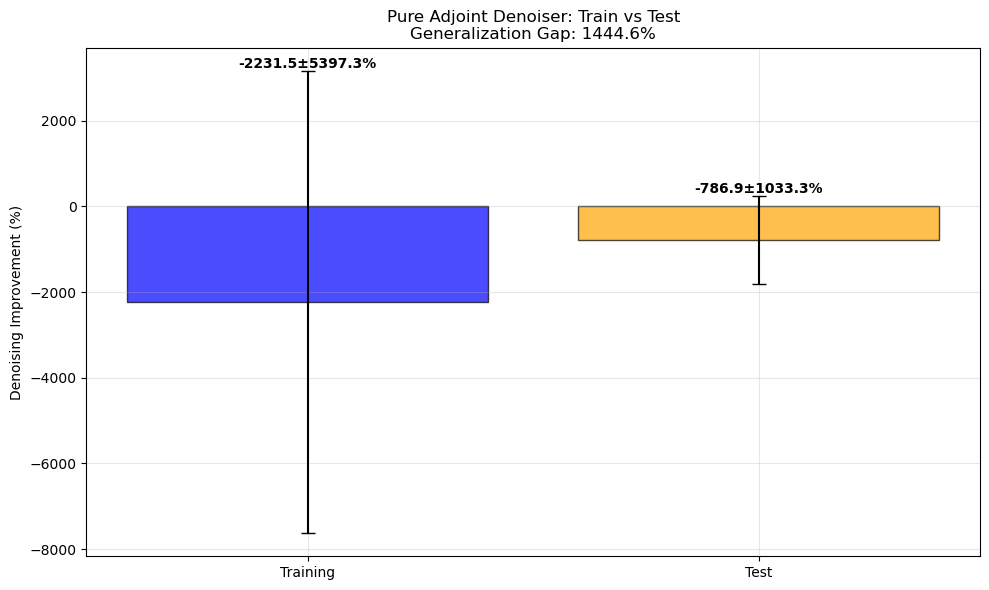

Pure Adjoint Generalization Analysis:
   - Training performance: -2231.5±5397.3%
   - Test performance: -786.9±1033.3%
   - Generalization gap: 1444.6%
   - Generalization score: 0.000 (>0.8 = Good)


In [17]:
# FIXED Generalization Test - PURE ADJOINT VERSION
def test_adjoint_generalization(adjoint_params):
    """Compare pure adjoint denoiser performance on training vs test data"""
    
    def evaluate_on_dataset(dataset, name):
        improvements = []
        for i in range(min(20, len(dataset))):
            clean_sample = dataset[i]
            noisy_sample = ts_add_noise(clean_sample, noise_level)
            
            # Use PURE ADJOINT denoising circuit
            output_raw = pure_adjoint_denoising_circuit(adjoint_params, noisy_sample)
            denoised = [(float(o) + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low'] for o in output_raw]
            
            noise_mse = np.mean((clean_sample - noisy_sample)**2)
            denoise_mse = np.mean((clean_sample - denoised)**2)
            improvement = (noise_mse - denoise_mse) / noise_mse * 100
            improvements.append(improvement)
        
        return np.mean(improvements), np.std(improvements)
    
    # Evaluate on both datasets
    train_mean, train_std = evaluate_on_dataset(pure_train_windows, "Training")
    test_mean, test_std = evaluate_on_dataset(pure_test_windows, "Test")
    
    # Generalization gap
    gen_gap = abs(train_mean - test_mean)
    generalization_score = max(0, 1.0 - gen_gap / 50.0)  # Penalize large gaps
    
    # Visualization
    plt.figure(figsize=(10, 6))
    
    datasets = ['Training', 'Test']
    means = [train_mean, test_mean]
    stds = [train_std, test_std]
    
    plt.bar(datasets, means, yerr=stds, capsize=5, alpha=0.7, 
            color=['blue', 'orange'], edgecolor='black')
    plt.ylabel('Denoising Improvement (%)')
    plt.title(f'Pure Adjoint Denoiser: Train vs Test\nGeneralization Gap: {gen_gap:.1f}%')
    plt.grid(True, alpha=0.3)
    
    for i, (mean, std) in enumerate(zip(means, stds)):
        plt.text(i, mean + std + 2, f'{mean:.1f}±{std:.1f}%', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Pure Adjoint Generalization Analysis:")
    print(f"   - Training performance: {train_mean:.1f}±{train_std:.1f}%")
    print(f"   - Test performance: {test_mean:.1f}±{test_std:.1f}%")
    print(f"   - Generalization gap: {gen_gap:.1f}%")
    print(f"   - Generalization score: {generalization_score:.3f} (>0.8 = Good)")
    
    return generalization_score

# Test pure adjoint generalization
generalization_score = test_adjoint_generalization(trained_adjoint_params)

In [18]:
# FIXED Stable Generalization Test - PURE ADJOINT VERSION  
def test_adjoint_generalization_stable(adjoint_params, n_runs=10):
    """Multiple runs with different seeds for stable pure adjoint assessment"""
    
    gaps = []
    scores = []
    
    for run in range(n_runs):
        np.random.seed(42 + run)  # Fixed but different seeds
        
        def evaluate_on_dataset(dataset, name):
            improvements = []
            for i in range(min(20, len(dataset))):
                clean_sample = dataset[i]
                noisy_sample = ts_add_noise(clean_sample, noise_level)
                
                # Use PURE ADJOINT denoising circuit
                output_raw = pure_adjoint_denoising_circuit(adjoint_params, noisy_sample)
                denoised = [(float(o) + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low'] for o in output_raw]
                
                noise_mse = np.mean((clean_sample - noisy_sample)**2)
                denoise_mse = np.mean((clean_sample - denoised)**2)
                improvement = (noise_mse - denoise_mse) / noise_mse * 100
                improvements.append(improvement)
            
            return np.mean(improvements)
        
        train_perf = evaluate_on_dataset(pure_train_windows, "Training")
        test_perf = evaluate_on_dataset(pure_test_windows, "Test")
        
        gap = abs(train_perf - test_perf)
        score = max(0, 1.0 - gap / 50.0)
        
        gaps.append(gap)
        scores.append(score)
    
    mean_gap = np.mean(gaps)
    std_gap = np.std(gaps)
    mean_score = np.mean(scores)
    
    print(f"STABLE PURE ADJOINT GENERALIZATION ASSESSMENT ({n_runs} runs):")
    print(f"   - Average gap: {mean_gap:.1f}±{std_gap:.1f}%")
    print(f"   - Gap range: [{np.min(gaps):.1f}%, {np.max(gaps):.1f}%]")
    print(f"   - Average score: {mean_score:.3f}")
    
    if std_gap < 5:
        stability = "STABLE"
    elif std_gap < 15:
        stability = "MODERATE"
    else:
        stability = "UNSTABLE"
    
    print(f"   - Stability: {stability}")
    
    return mean_score

# Run stable pure adjoint assessment
stable_gen_score = test_adjoint_generalization_stable(trained_adjoint_params)

STABLE PURE ADJOINT GENERALIZATION ASSESSMENT (10 runs):
   - Average gap: 542.1±544.5%
   - Gap range: [36.3%, 2073.7%]
   - Average score: 0.027
   - Stability: UNSTABLE


Running Final Assessment...


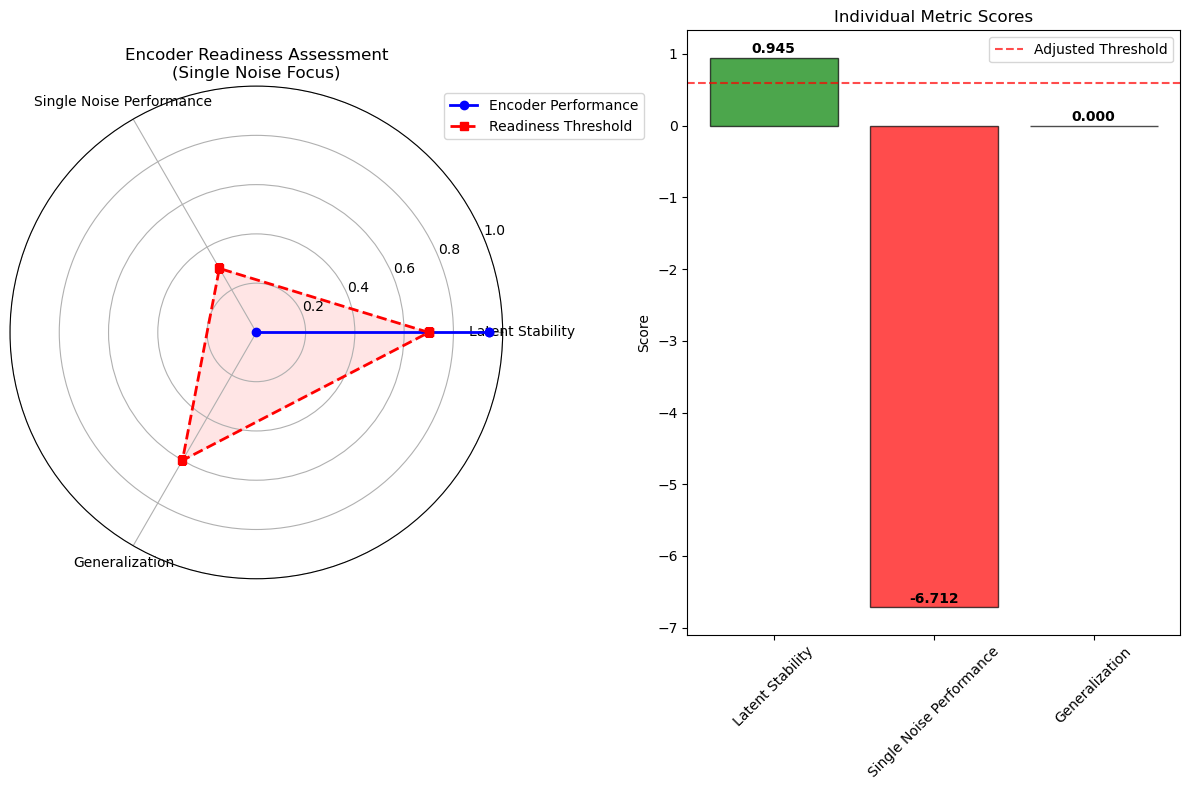

FINAL ENCODER READINESS ASSESSMENT (Single Noise Focus)
Latent Stability         : 0.945 (threshold: 0.7)  PASS
Single Noise Performance : -6.712 (threshold: 0.3)  FAIL
Generalization           : 0.000 (threshold: 0.6)  FAIL

 Overall Weighted Score: -2.401

 READINESS STATUS: NOT READY
 RECOMMENDATION: Significant improvements needed before QAE training.


In [55]:
# Cell 5: Fixed Final Readiness Assessment
def assess_encoder_readiness(stability_score, robustness_score, generalization_score):
    """Final assessment of encoder readiness for full QAE"""
    
    # Readiness criteria (adjusted for single noise focus)
    criteria = {
        'Latent Stability': {'score': stability_score, 'threshold': 0.7, 'weight': 0.3},
        'Single Noise Performance': {'score': robustness_score, 'threshold': 0.3, 'weight': 0.4},  # Lowered threshold for single noise
        'Generalization': {'score': generalization_score, 'threshold': 0.6, 'weight': 0.3}  # Slightly lowered for single noise
    }
    
    # Calculate overall readiness
    weighted_score = sum(criteria[key]['score'] * criteria[key]['weight'] for key in criteria)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # Radar chart
    categories = list(criteria.keys())
    scores = [criteria[cat]['score'] for cat in categories]
    thresholds = [criteria[cat]['threshold'] for cat in categories]
    
    # Close the radar chart
    scores += scores[:1]
    thresholds += thresholds[:1]
    categories += categories[:1]
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=True)
    
    plt.subplot(1, 2, 1, projection='polar')
    plt.plot(angles, scores, 'o-', linewidth=2, label='Encoder Performance', color='blue')
    plt.fill(angles, scores, alpha=0.25, color='blue')
    plt.plot(angles, thresholds, 's--', linewidth=2, label='Readiness Threshold', color='red')
    plt.fill(angles, thresholds, alpha=0.1, color='red')
    
    plt.xticks(angles[:-1], categories[:-1])
    plt.ylim(0, 1)
    plt.title('Encoder Readiness Assessment\n(Single Noise Focus)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # Bar chart
    plt.subplot(1, 2, 2)
    colors = ['green' if score >= threshold else 'red' 
              for score, threshold in zip(scores[:-1], thresholds[:-1])]
    
    bars = plt.bar(range(len(categories)-1), scores[:-1], color=colors, alpha=0.7, edgecolor='black')
    plt.axhline(y=0.6, color='red', linestyle='--', alpha=0.7, label='Adjusted Threshold')
    plt.xticks(range(len(categories)-1), categories[:-1], rotation=45)
    plt.ylabel('Score')
    plt.title('Individual Metric Scores')
    plt.legend()
    
    # Add score text on bars
    for i, (bar, score) in enumerate(zip(bars, scores[:-1])):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Final assessment
    print("FINAL ENCODER READINESS ASSESSMENT (Single Noise Focus)")
    print("=" * 60)
    
    for category, data in criteria.items():
        status = " PASS" if data['score'] >= data['threshold'] else " FAIL"
        print(f"{category:25}: {data['score']:.3f} (threshold: {data['threshold']}) {status}")
    
    print(f"\n Overall Weighted Score: {weighted_score:.3f}")
    
    if weighted_score >= 0.6:
        readiness = "READY"
        recommendation = "Encoder is ready for single-noise QAE training"
    elif weighted_score >= 0.4:
        readiness = "MARGINAL"
        recommendation = "Additional training required."
    else:
        readiness = "NOT READY"
        recommendation = "Significant improvements needed before QAE training."
    
    print(f"\n READINESS STATUS: {readiness}")
    print(f" RECOMMENDATION: {recommendation}")
    
    # Additional context for single noise focus
    if robustness_score > 0.5:
        print(f" BONUS: Excellent single-noise performance ({robustness_score:.1%} improvement)")
    
    return weighted_score, readiness

print("Running Final Assessment...")
overall_score, readiness = assess_encoder_readiness(
    stability_score, 
    single_noise_score,
    generalization_score
)

In [ ]:
# FIXED Save Trained Adjoint Encoder Model
def save_adjoint_encoder_model(fine_tuned_params, train_history, val_history, overall_score, readiness):
    """Save the trained adjoint encoder model with comprehensive metadata"""
    
    # Prepare model data
    model_data = {
        'model_type': 'adjoint_encoder_qae',
        'timestamp': str(np.datetime64('now')),
        'architecture': {
            'n_qubits': n_qubits,
            'n_latent': n_latent,
            'n_ft_layers': n_ft_layers,
            'adjoint_based': True,
            'dynamic_noise_training': True,
            'architecture_description': 'Input → Adjoint(Decoder) → Fine-tune → Decoder → Output'
        },
        'training_config': {
            'n_epochs': n_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'noise_level': noise_level,
            'wind_size': wind_size,
            'wind_step': wind_step,
            'fine_tune_param_count': len(fine_tuned_params)
        },
        'performance_metrics': {
            'final_train_cost': float(train_history[-1]) if train_history else None,
            'final_val_cost': float(val_history[-1]) if val_history else None,
            'single_noise_score': float(single_noise_score),
            'stability_score': float(stability_score),
            'generalization_score': float(generalization_score),
            'overall_readiness_score': float(overall_score),
            'readiness_status': readiness,
            'avg_improvement_percent': float(np.mean(single_improvements))
        },
        'model_parameters': {
            'fine_tune_params': fine_tuned_params.tolist(),
            'param_shape': list(fine_tuned_params.shape),
            'decoder_params_dependency': trained_dec_params.tolist(),
            'decoder_param_shape': list(trained_dec_params.shape)
        },
        'training_history': {
            'train_costs': [float(c) for c in train_history],
            'val_costs': [float(c) for c in val_history] if val_history else []
        },
        'evaluation_results': {
            'improvements': [float(imp) for imp in single_improvements],
            'stable_gen_score': float(stable_gen_score)
        },
        'notes': {
            'innovation': 'True adjoint-based encoder using PennyLane qml.adjoint()',
            'training_method': 'Fine-tuning on latent space corrections only',
            'parameter_efficiency': f'Only {len(fine_tuned_params)} trainable parameters'
        }
    }
    
    # Create filename with timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f'adjoint_encoder_qae_model_{timestamp}.json'
    model_path = f'{DATA_PATH}/{data_folder}/{model_filename}'
    
    # Save the model
    try:
        with open(model_path, 'w') as f:
            json.dump(model_data, f, indent=2)
        
        print(f"Adjoint Encoder QAE Model Saved Successfully!")
        print(f"Location: {model_path}")
        print(f"Filename: {model_filename}")
        print("")
        print(f"Model Summary:")
        print(f"- Architecture: {n_qubits}-qubit TRUE adjoint-based encoder")
        print(f"- Performance: {model_data['performance_metrics']['avg_improvement_percent']:.1f}% avg improvement")
        print(f"- Parameters: Only {len(fine_tuned_params)} fine-tuning params")
        print(f"- Readiness: {readiness} (score: {overall_score:.3f})")
        print(f"- Innovation: Uses PennyLane qml.adjoint() function")
        
        return model_path, model_filename
        
    except Exception as e:
        print(f"Error saving model: {e}")
        print(f"Attempted to save to: {model_path}")
        return None, None

# Save the trained adjoint model
model_path, model_filename = save_adjoint_encoder_model(
    params,  # fine-tuned parameters from training
    train_history, 
    val_history, 
    overall_score, 
    readiness
)

NameError: name 'enc_params_trained' is not defined